In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
from matplotlib.transforms import blended_transform_factory
from itertools import product
import pandas as pd
import seaborn as sns

from pypet.trajectory import Trajectory
import collective_behavior_analysis as cba


def load_result(filename, vis_input_method):
    traj = Trajectory(filename=filename)

    # Now we want to load all stored data.
    traj.f_load(index=-1, load_parameters=2, load_results=1)
    traj.v_auto_load = True

    par_names = ['speed0', 'noisep', 'seed']
    filter_params = ['vis_input_method']
    filter_func = lambda vis_method: vis_method == vis_input_method

    result_specs = {'names': ['startle_freq'],
                    'funcs': [cba.calcStartlingFrequencyWithBurning],
                    'input_variables': [['results.outdata.crun.startle', 'par.total_time',
                                         'par.output']]}
    time_result_specs = {'names': ['pol', 'coh'],
                         'funcs': [cba.calcPolarization, cba.get_calcCohesion('nearest')],
                         'input_variables': [['results.outdata.crun.uw'],
                                             ['results.outdata.crun.pos']]}

    res, time_res, ranges, unique_vals, lengths = cba.collect_filtered_results(traj, par_names,
                                                                               result_specs,
                                                                               time_result_specs,
                                                                               filter_params,
                                                                               filter_func)
    return res, time_res, ranges, unique_vals, lengths


filename = os.path.join(os.path.expanduser('/extra/swarmstartle_results'),
                        'looming_swarm_fitted_model_high_resolution.hdf5')

In [37]:
def CalcDistVecMatrix(pos, L, BC):
    """ Calculate N^2 distance matrix (d_ij)

        Returns:
        --------
        distmatrix - matrix of all pairwise distances (NxN)
        dX - matrix of all differences in x coordinate (NxN)
        dY - matrix of all differences in y coordinate (NxN)
    """
    X = np.reshape(pos[:, 0], (-1, 1))
    Y = np.reshape(pos[:, 1], (-1, 1))
    dX = np.subtract(X, X.T)
    dY = np.subtract(Y, Y.T)
    dX_period = np.copy(dX)
    dY_period = np.copy(dY)
    if BC == 0:
        dX_period[dX > +0.5 * L] -= L
        dY_period[dY > +0.5 * L] -= L
        dX_period[dX < -0.5 * L] += L
        dY_period[dY < -0.5 * L] += L
    distmatrix = np.sqrt(dX_period ** 2 + dY_period ** 2)
    return distmatrix, dX_period, dY_period


def PeriodicDist(x, y, L=10.0, dim=2):
    """ Returns the distance vector of two position vectors x,y
        by tanking periodic boundary conditions into account.

        Input parameters: L - system size, dim - number of dimensions
    """
    distvec = (y - x)
    distvec_periodic = np.copy(distvec)
    distvec_periodic[distvec < -0.5 * L] += L
    distvec_periodic[distvec > 0.5 * L] -= L

    return distvec_periodic


def calcCohesion(pos, L, BC, method='nearest'):
    from scipy.spatial import ConvexHull
    ntimesteps = pos.shape[0]
    coh = np.empty(ntimesteps)
    for t in np.arange(ntimesteps):
        if method == 'nearest':
            dist_mat, dx, dy = CalcDistVecMatrix(pos[t, :, :], L, BC)
            np.fill_diagonal(dist_mat, np.inf)
            min_dists = np.min(dist_mat, axis=0)
            current_cohesion = np.mean(min_dists)
        elif method == 'convexhull':
            hull = ConvexHull(pos[t, :, :])
            # volume is referring to a 3D setting so in a 2D case it gives the area
            current_cohesion = hull.volume
        elif method == 'inter':
            dist_mat, dx, dy = CalcDistVecMatrix(pos[t, :, :], L, BC)
            np.fill_diagonal(dist_mat, np.nan)
            mean_dists = np.nanmean(dist_mat, axis=0)
            current_cohesion = np.mean(mean_dists)
        else:
            current_cohesion = 0
        coh[t] = current_cohesion
    return coh


def calc_periodic_mass_center(pos, arena_size):
    periodic_center = np.zeros(2)
    norm_term = 2*np.pi/arena_size
    for dim_idx in range(2):
        circ_coords = np.zeros((pos.shape[0], 2))
        circ_coords[:, 0] = np.cos((pos[:, dim_idx] * norm_term)) / norm_term
        circ_coords[:, 1] = np.sin((pos[:, dim_idx] * norm_term)) / norm_term
        mean_circ_coords = np.mean(circ_coords, axis=0)
        mean_angle = np.arctan2(-mean_circ_coords[1], -mean_circ_coords[0]) + np.pi
        periodic_center[dim_idx] = mean_angle/norm_term
    return periodic_center


def calcStartlePosition(pos, startles, L, output_step, burn_period = 50, cohesion_measures=None):
    burn_period_steps = int(burn_period/output_step)
    ntimesteps = pos.shape[0]
    startle_dists = np.array([])
    startle_distvecs = None
    for t in np.arange(burn_period_steps, ntimesteps):
        startle_idc = np.where(startles[t, :])[0]
        if startle_idc.size == 0:
            continue
        else:
            cmass_center = calc_periodic_mass_center(pos[t, :, :], L)
            center_distvecs = PeriodicDist(cmass_center, pos[t, :, :], L)
            if cohesion_measures is not None:
                center_distvecs = center_distvecs/cohesion_measures[t]
                
            center_dists = np.sqrt(center_distvecs[:, 0] ** 2 + center_distvecs[:, 1] ** 2)

            startle_dists = np.concatenate((startle_dists, center_dists[startle_idc]))
            if startle_distvecs is None:
                startle_distvecs = center_distvecs[startle_idc]
            else:
                startle_distvecs = np.concatenate((startle_distvecs, center_distvecs[startle_idc]))
    return startle_dists, startle_distvecs


def calcRelativePosition(pos, L, output_step, burn_period = 50, cohesion_measures=None):
    burn_period_steps = int(burn_period/output_step)
    ntimesteps = pos.shape[0]
    all_dists = np.array([])
    all_distvecs = None
    for t in np.arange(burn_period_steps, ntimesteps):
        cmass_center = calc_periodic_mass_center(pos[t, :, :], L)
        center_distvecs = PeriodicDist(cmass_center, pos[t, :, :], L)
        if cohesion_measures is not None:
            center_distvecs = center_distvecs/cohesion_measures[t]

        center_dists = np.sqrt(center_distvecs[:, 0] ** 2 + center_distvecs[:, 1] ** 2)
        all_dists = np.concatenate((all_dists, center_dists))
        if all_distvecs is None:
            all_distvecs = center_distvecs
        else:
            all_distvecs = np.concatenate((all_distvecs, center_distvecs))
    return all_dists, all_distvecs


def calcPolarization(direction_vecs):
    """
    Calculates the group polarization.

    We use the definition by Couzin et. al 2002 here:
    p_group(t) = 1/N * |sum from {i=1} to {N} (v_i(t)|

    where N is the number of agents and v_i is a unit direction vector.

    :param outData:
        The simulation output as defined in SwarmStartle.
    :return:
    """
    mean_ux = np.mean(direction_vecs[:, :, 0], axis=1)
    mean_uy = np.mean(direction_vecs[:, :, 1], axis=1)
    return np.sqrt(mean_ux**2 + mean_uy**2)


def calcStartleOrientation(uw, pos, startles, L, output_step, burn_period = 50):
    burn_period_steps = int(burn_period/output_step)
    ntimesteps = pos.shape[0]
    all_orientations = np.array([])
    all_frontness = np.array([])
    startle_orientations = np.array([])
    startle_frontness = np.array([])
    for t in np.arange(burn_period_steps, ntimesteps):
        startle_idc = np.where(startles[t, :])[0]
        if startle_idc.size == 0:
            continue
        else:
            cmass_center = calc_periodic_mass_center(pos[t, :, :], L)
            center_distvecs = PeriodicDist(cmass_center, pos[t, :, :], L)
            
            mean_uw = np.mean(uw[t, :, :], axis=0)
            mean_uw_unit = mean_uw/np.linalg.norm(mean_uw)
            frontness_vals = center_distvecs[:, 0]*mean_uw_unit[0] + center_distvecs[:, 1]*mean_uw_unit[1]
            orientations = uw[t, :, 0]*mean_uw_unit[0] + uw[t, :, 1]*mean_uw_unit[1]
            
            all_orientations = np.concatenate((all_orientations, orientations))
            all_frontness = np.concatenate((all_frontness, frontness_vals))
            
            startle_orientations = np.concatenate((startle_orientations, orientations[startle_idc]))
            startle_frontness = np.concatenate((startle_frontness, frontness_vals[startle_idc]))
    return startle_orientations, startle_frontness, all_orientations, all_frontness


def calcCascadeSizes(startles, output_step, time_margin=0.2):
    """Calculates the sizes of startle cascades.

    Parameters
    ----------
    startles
        An array with booleans for each agent and time point.

    Returns
    -------

    """
    time_margin_steps = int(time_margin/output_step)
    ntimesteps = startles.shape[0]
    ncascades = 0
    cascade_sizes = []
    cascade_lengths = []
    single_startle = False
    ongoing_cascade = False
    current_cascade_members = []
    previous_startle_idc = []
    last_startle_time_idx = 0
    current_cascade_length = 0
    starting_points = []
    for t in np.arange(ntimesteps):
        startle_idc = np.where(startles[t, :])[0]
        time_since_last_startle = t - last_startle_time_idx
        # no startles at current time step:
        if startle_idc.size == 0:
            if ongoing_cascade and time_since_last_startle > time_margin_steps:
                cascade_sizes.append(len(current_cascade_members))
                cascade_lengths.append(current_cascade_length)
                ncascades += 1
                ongoing_cascade = False
                current_cascade_members = []
                current_cascade_length = 0
            else:
                if single_startle and time_since_last_startle > time_margin_steps:
                    single_startle = False
                    current_cascade_members = []
                    current_cascade_length = 0
        # at least one fish startled:
        else:
            if ongoing_cascade:
                new_members = []
                for startle_idx in startle_idc:
                    if startle_idx not in previous_startle_idc:
                        new_members.append(startle_idx)
                if not len(new_members) == 0:
                    current_cascade_members.extend(new_members)
                current_cascade_length += 1
            else:
                if single_startle:
                    new_members = []
                    for startle_idx in startle_idc:
                        if startle_idx not in previous_startle_idc:
                            new_members.append(startle_idx)
                    if not len(new_members) == 0:
                        single_startle = False
                        ongoing_cascade = True
                        starting_points.append(t-1)
                        current_cascade_members.extend(new_members)
                    current_cascade_length += 1
                else:
                    single_startle = True
                    current_cascade_members.extend(startle_idc)
                    current_cascade_length += 1
            last_startle_time_idx = t
            previous_startle_idc = startle_idc
    return np.array(cascade_sizes), np.array(cascade_lengths), np.array(starting_points)

In [40]:
traj = Trajectory(filename=filename)

# Now we want to load all stored data.
traj.f_load(index=-1, load_parameters=2, load_results=1)
traj.v_auto_load = True

filter_params = ['speed0', 'noisep']
filter_func = lambda speed0, noisep: speed0 == 1.75 and noisep == 0.01

idx_iterator = traj.f_find_idx(filter_params, filter_func)

pos_data = []
uw_data = []
vis_method_data = []
startle_data = []
vm_data = []
# fill result arrays
for run_idx in idx_iterator:
    traj.v_idx = run_idx
    pos_data.append(traj.f_get('results.outdata.crun.pos', fast_access=True, auto_load=True))
    uw_data.append(traj.f_get('results.outdata.crun.uw', fast_access=True, auto_load=True))
    vis_method_data.append(traj.f_get('vis_input_method', fast_access=True, auto_load=True))
    startle_data.append(traj.f_get('results.outdata.crun.startle', fast_access=True, auto_load=True))
    vm_data.append(traj.f_get('results.outdata.crun.v_m', fast_access=True, auto_load=True))

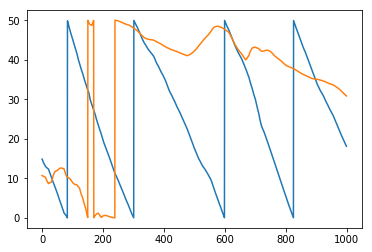

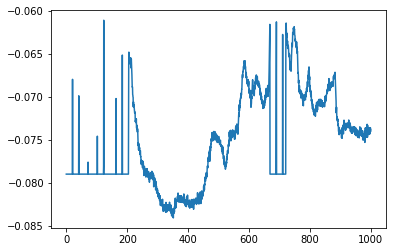

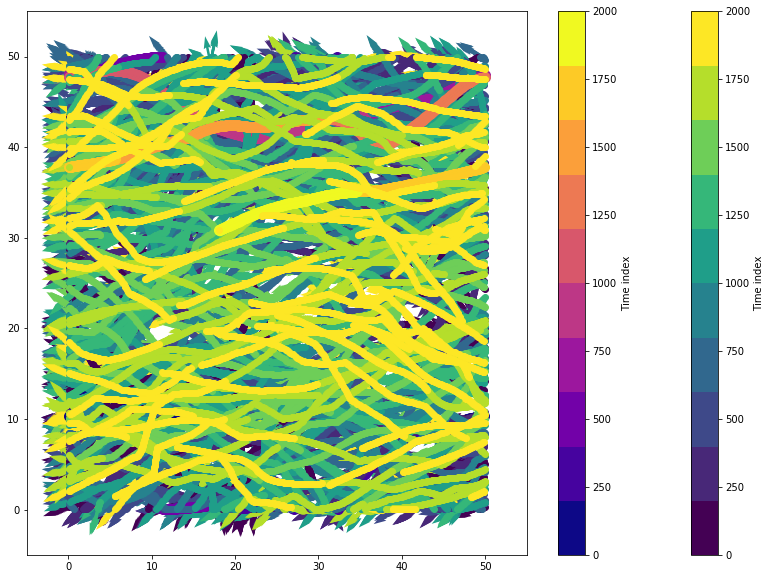

In [14]:
tstart = 0
tend = 2000
focal_agent = 1
a = pos_data[0]
b = vm_data[0]
plt.plot(np.arange(tstart, tend)*0.5, a[tstart:tend, focal_agent])

plt.figure()
plt.plot(np.arange(tstart, tend)*0.5, b[tstart:tend, focal_agent])

plt.figure(figsize=(14, 10))
#plt.plot(pos_data[0][tstart, :, 0], pos_data[0][tstart, :, 1], 'k.', ms=20)
#plt.quiver(pos_data[0][tstart, :, 0], pos_data[0][tstart, :, 1], uw_data[0][tstart, :, 0], uw_data[0][tstart, :, 1],
#           width=0.005)

import matplotlib as mpl
vmin = np.min(tstart)
vmax = np.max(tend)
plot_cmap = plt.cm.get_cmap('viridis', 10)
sm = plt.cm.ScalarMappable(cmap=plot_cmap, norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))

plasma_cmap = plt.cm.get_cmap('plasma', 10)
plasma_sm = plt.cm.ScalarMappable(cmap=plasma_cmap, norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))

for t_idx in np.arange(tstart, tend, step=1):
    plt.plot(pos_data[0][t_idx, focal_agent, 0], pos_data[0][t_idx, focal_agent, 1], '.', c=plasma_sm.to_rgba(t_idx), ms=20)
    plt.quiver(pos_data[0][t_idx, focal_agent, 0], pos_data[0][t_idx, focal_agent, 1], uw_data[0][t_idx, focal_agent, 0],
               uw_data[0][t_idx, focal_agent, 1], color=plasma_sm.to_rgba(t_idx), width=0.005)
    
    plt.plot(pos_data[0][t_idx, :, 0], pos_data[0][t_idx, :, 1], '.', ms=12, c=sm.to_rgba(t_idx))
    plt.quiver(pos_data[0][t_idx, :, 0], pos_data[0][t_idx, :, 1], uw_data[0][t_idx, :, 0],
               uw_data[0][t_idx, :, 1], color=sm.to_rgba(t_idx), width=0.005)

sm.set_array([])
plt.colorbar(sm, label='Time index')
plasma_sm.set_array([])
plt.colorbar(plasma_sm, label='Time index')
plt.xlim([-5, 55])
plt.ylim([-5, 55])
plt.show()

# Startling vs. relative Position

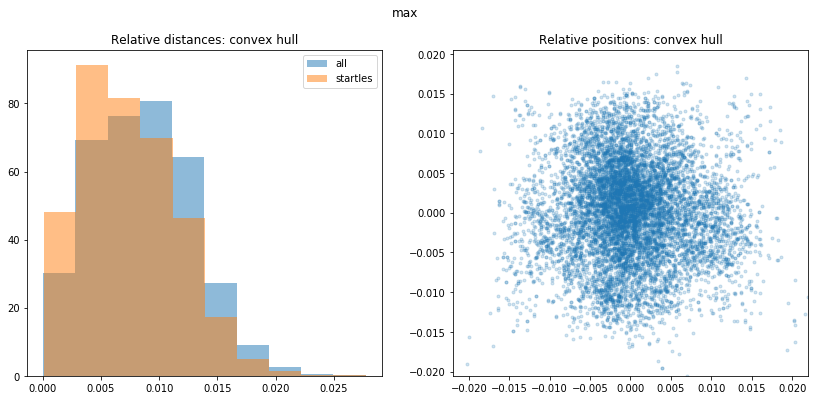

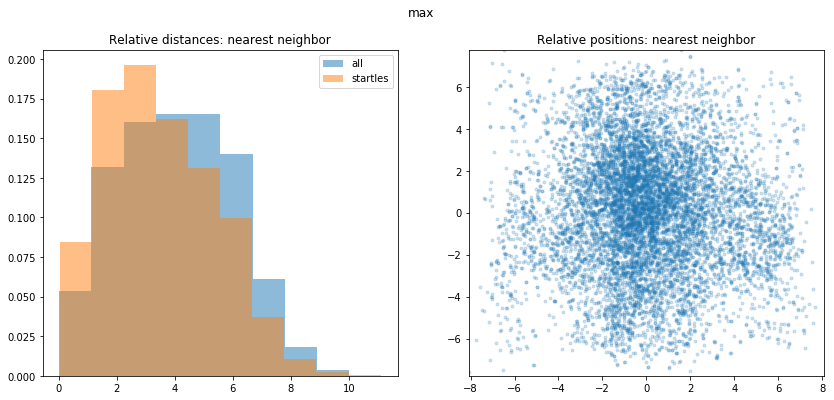

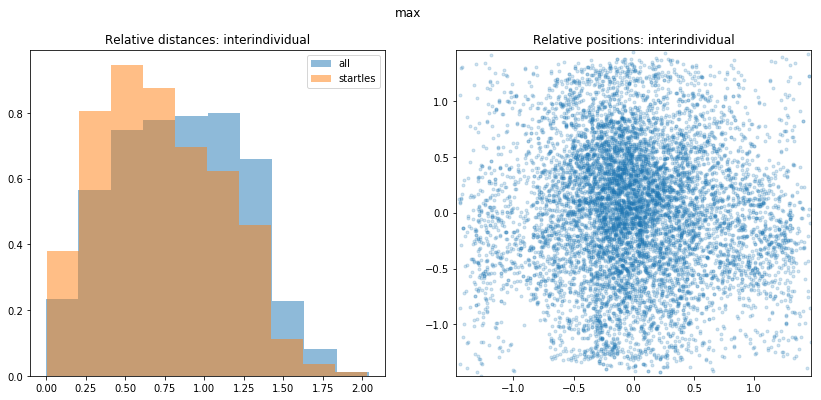

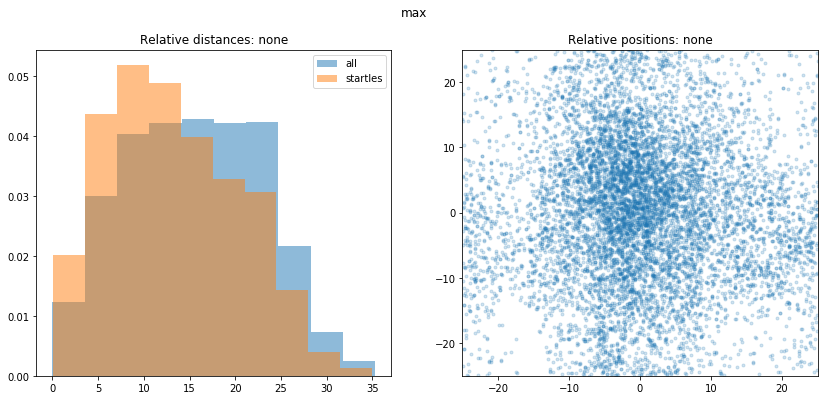

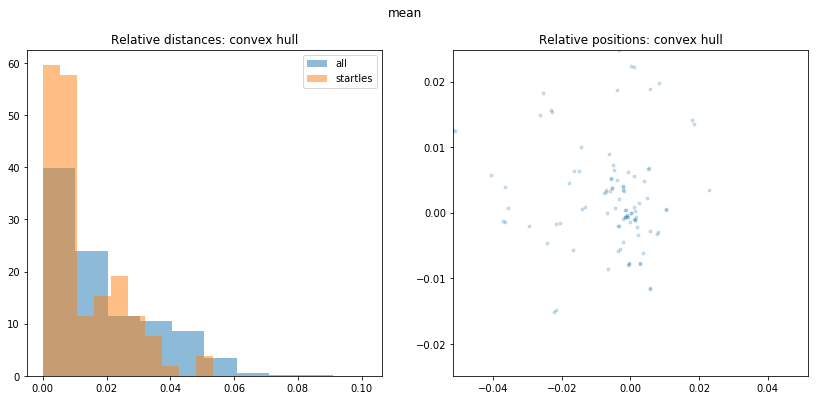

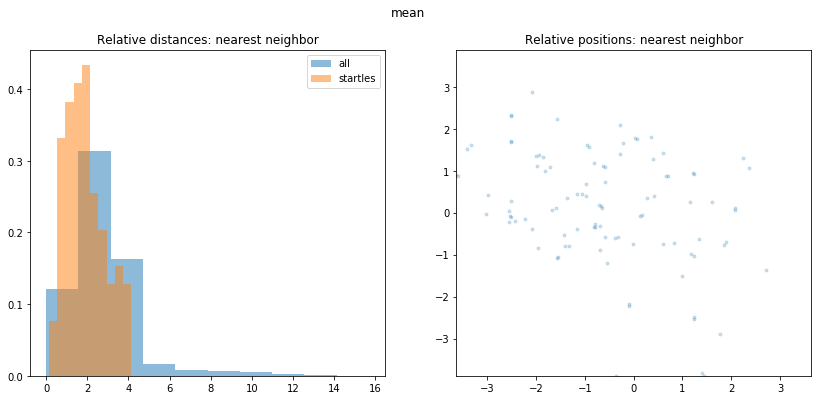

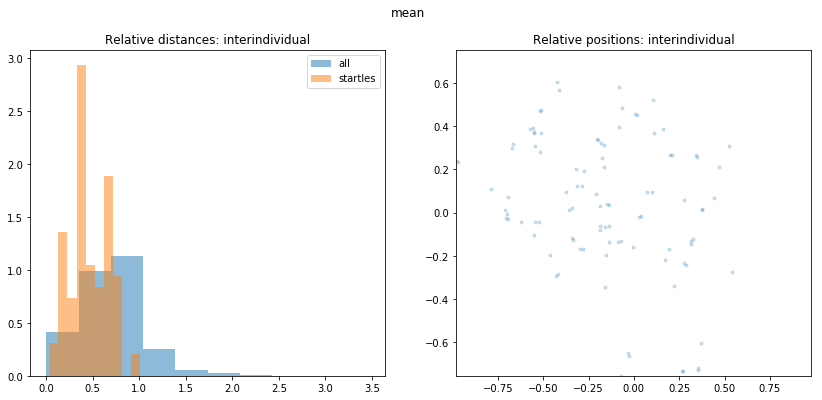

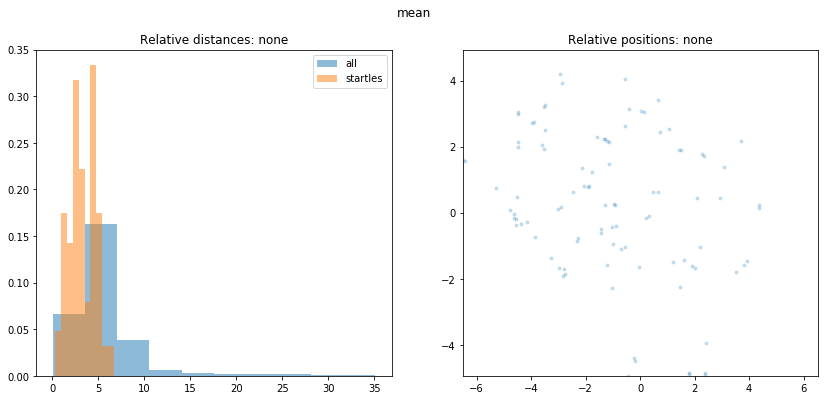

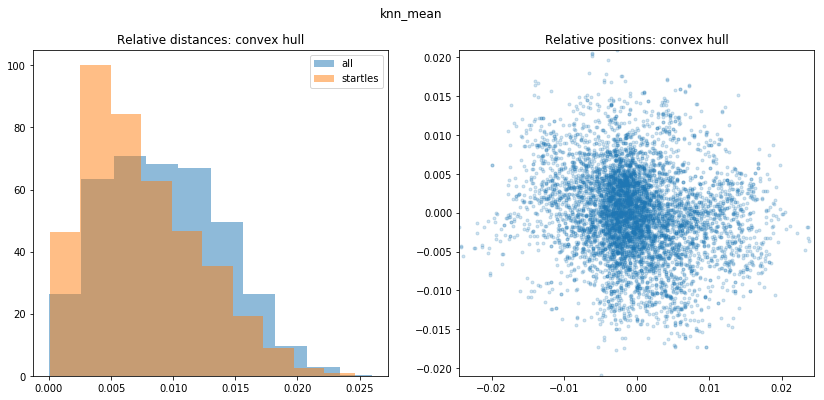

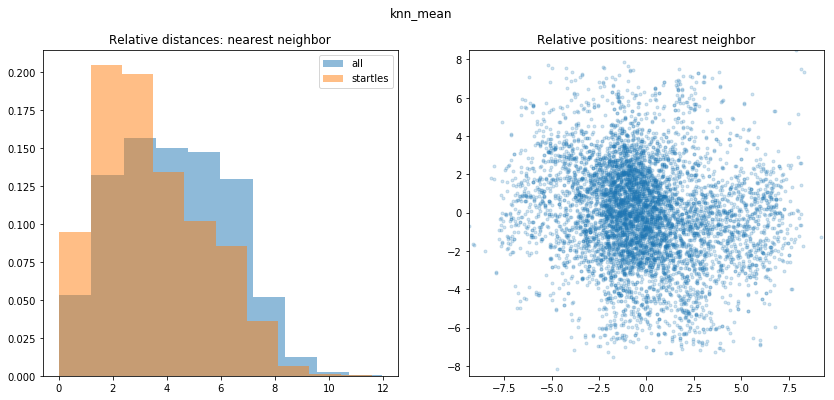

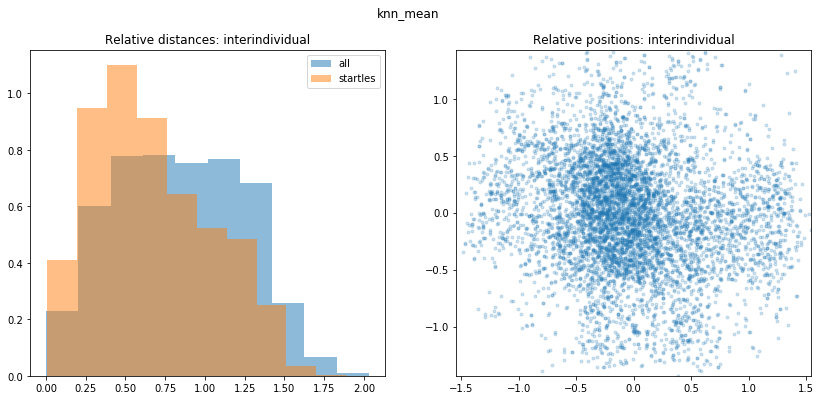

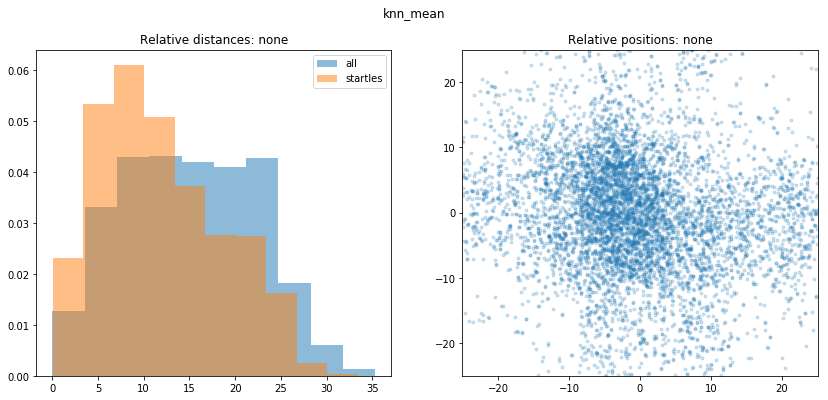

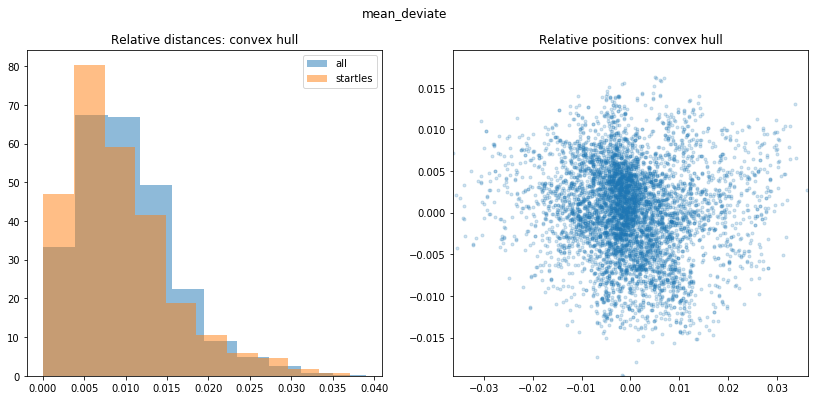

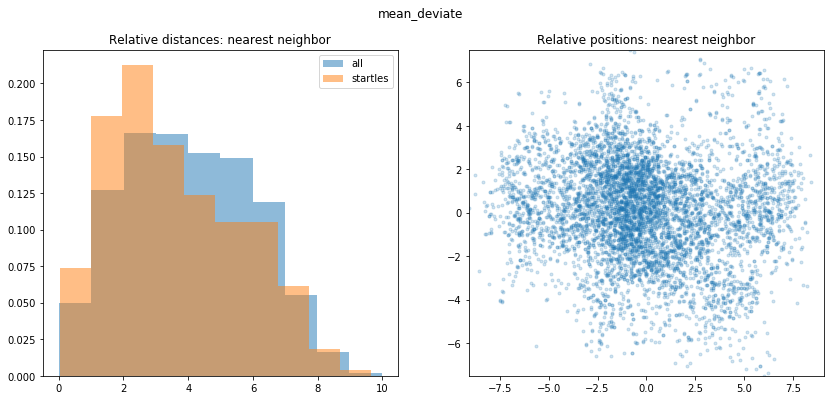

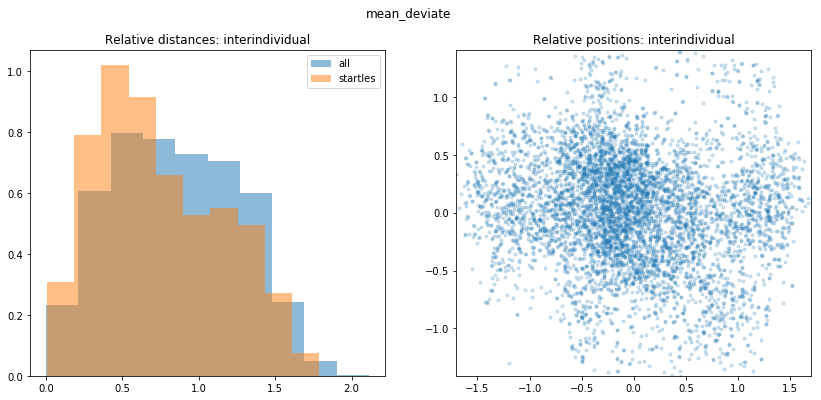

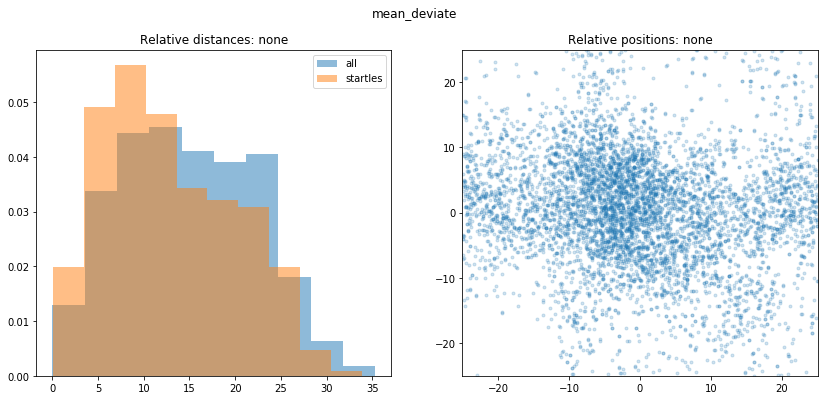

/home/warkentin/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


TypeError: 'NoneType' object is not subscriptable

In [19]:
for data_idx in range(len(pos_data)):    
    conv_coh = calcCohesion(np.array(pos_data[data_idx]), traj.par.L, traj.par.BC , method='convexhull')
    nn_coh = calcCohesion(np.array(pos_data[data_idx]), traj.par.L, traj.par.BC , method='nearest')
    ii_coh = calcCohesion(np.array(pos_data[data_idx]), traj.par.L, traj.par.BC , method='inter')

    burn_period = 30
    ntimesteps = pos_data[data_idx].shape[0]
    coh_methods = ['convex hull', 'nearest neighbor', 'interindividual', 'none']
    for coh_idx, coh_values in enumerate([conv_coh, nn_coh, ii_coh, None]):
        startle_dists, startle_distvecs = calcStartlePosition(pos_data[data_idx], startle_data[data_idx], traj.par.L,
                                                              traj.par.output, burn_period, coh_values)
        all_dists, all_distvecs = calcRelativePosition(pos_data[data_idx], traj.par.L, traj.par.output, burn_period,
                                                       coh_values)
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
        ax1.hist(all_dists, density=True, label='all', alpha=0.5)
        ax1.hist(startle_dists, density=True, label='startles', alpha=0.5)
        #plt.title('Euclidean distances relative to cohesion measured by: ' + coh_methods[coh_idx])
        ax1.set_title('Relative distances: ' + coh_methods[coh_idx])
        ax1.legend()

        ax2.plot(startle_distvecs[:, 0], startle_distvecs[:, 1], '.', alpha=0.2)
        xmin = np.min(startle_distvecs[:, 0])
        xmax = np.max(startle_distvecs[:, 0])
        xmax_abs = np.max(np.abs([xmin, xmax]))
        ymin = np.min(startle_distvecs[:, 1])
        ymax = np.max(startle_distvecs[:, 1])
        ymax_abs = np.max(np.abs([ymin, ymax]))
        ax2.set_xlim([-xmax_abs, xmax_abs])
        ax2.set_ylim([-ymax_abs, ymax_abs])
        #ax2.set_title('Positions from center of mass (0,0) relative to cohesion measured by: ' + coh_methods[coh_idx])
        ax2.set_title('Relative positions: ' + coh_methods[coh_idx])
        plt.suptitle(vis_method_data[data_idx])
    plt.show()

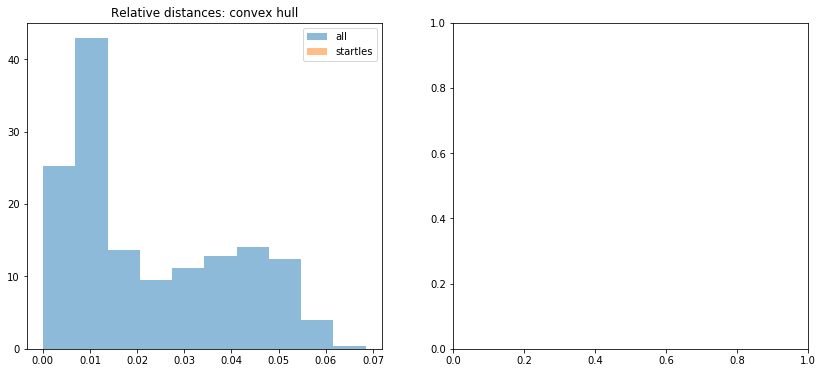

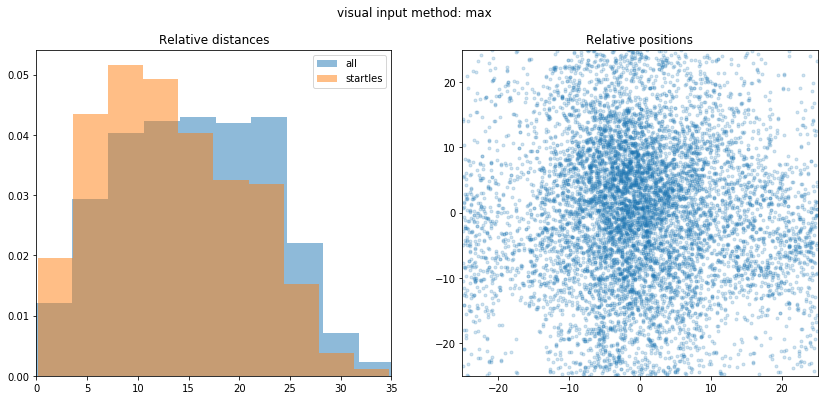

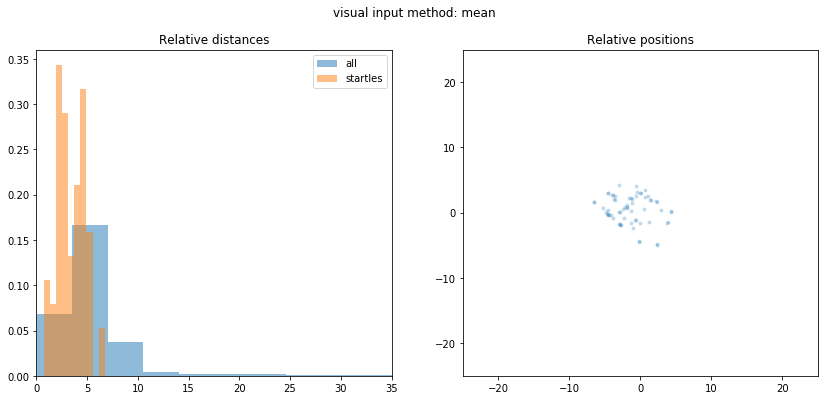

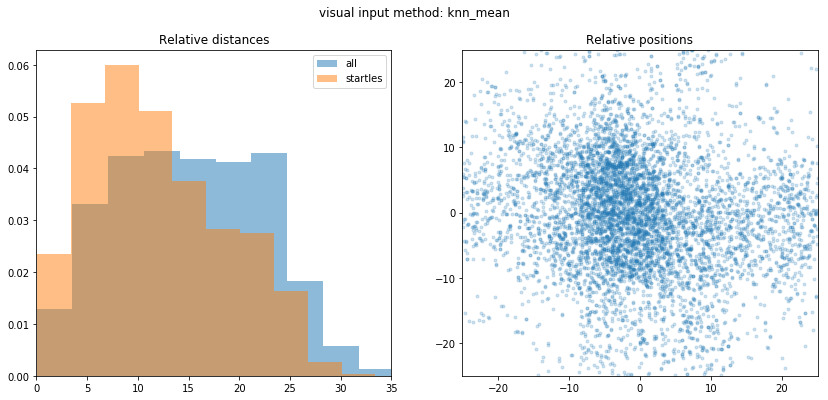

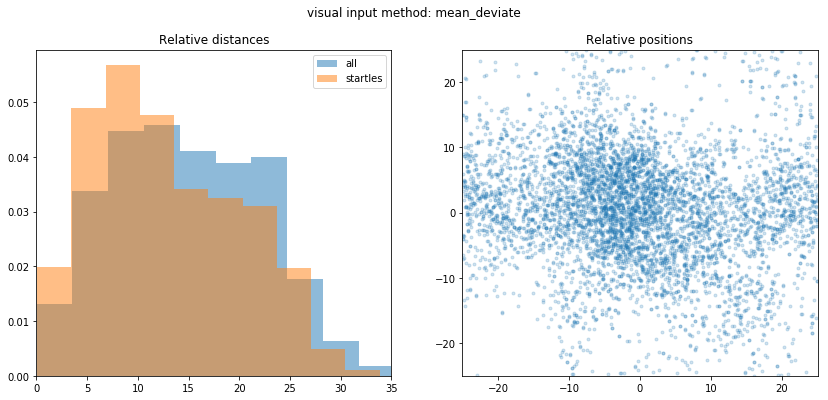

/home/warkentin/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


TypeError: 'NoneType' object is not subscriptable

In [21]:
for data_idx in range(5):    
    burn_period = 50
    
    startle_dists, startle_distvecs = calcStartlePosition(pos_data[data_idx], startle_data[data_idx], traj.par.L,
                                                          traj.par.output, burn_period, None)
    all_dists, all_distvecs = calcRelativePosition(pos_data[data_idx], traj.par.L, traj.par.output, burn_period, None)
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    ax1.hist(all_dists, density=True, label='all', alpha=0.5)
    ax1.hist(startle_dists, density=True, label='startles', alpha=0.5)
    #plt.title('Euclidean distances relative to cohesion measured by: ' + coh_methods[coh_idx])
    ax1.set_title('Relative distances')
    ax1.set_xlim([0, 35])
    ax1.legend()

    ax2.plot(startle_distvecs[:, 0], startle_distvecs[:, 1], '.', alpha=0.2)
    xmin = np.min(startle_distvecs[:, 0])
    xmax = np.max(startle_distvecs[:, 0])
    xmax_abs = np.max(np.abs([xmin, xmax]))
    ymin = np.min(startle_distvecs[:, 1])
    ymax = np.max(startle_distvecs[:, 1])
    ymax_abs = np.max(np.abs([ymin, ymax]))
    #ax2.set_xlim([-xmax_abs, xmax_abs])
    #ax2.set_ylim([-ymax_abs, ymax_abs])
    
    ax2.set_xlim([-25, 25])
    ax2.set_ylim([-25, 25])
    #ax2.set_title('Positions from center of mass (0,0) relative to cohesion measured by: ' + coh_methods[coh_idx])
    ax2.set_title('Relative positions')
    plt.suptitle('visual input method: ' + vis_method_data[data_idx])
    plt.show()

In [22]:
pol = calcPolarization(uw_data[0])
pol.shape

(10001,)

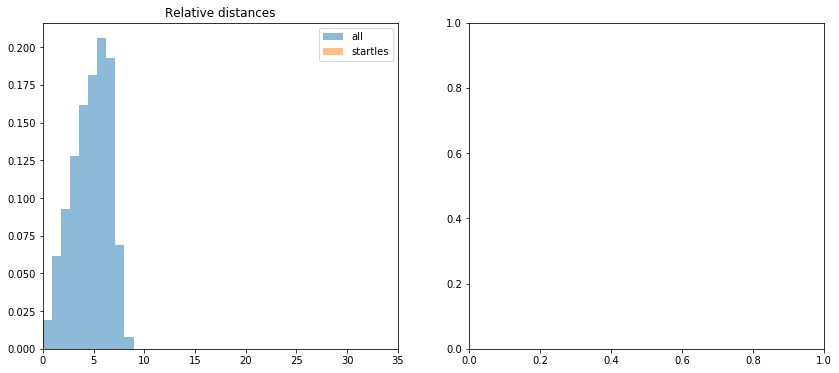

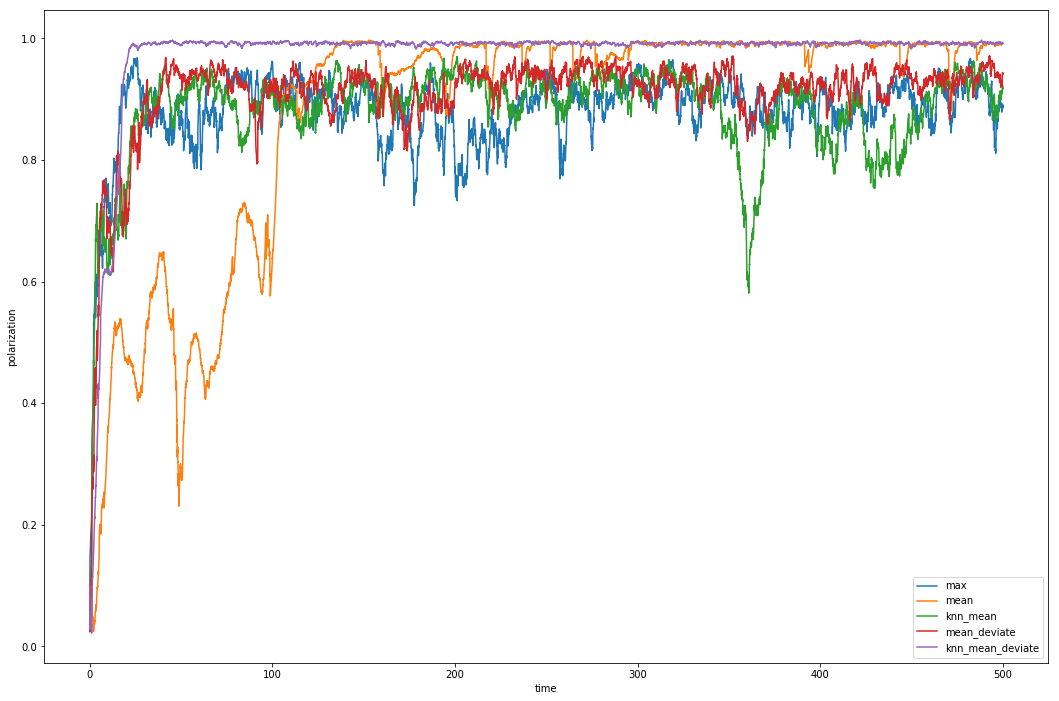

In [24]:
plt.figure(figsize=(18,12))
for i in range(5):
    pol = calcPolarization(uw_data[i])
    
    plt.plot(np.arange(len(pol))*traj.par.output, pol, label=vis_method_data[i])
    plt.xlabel('time')
    plt.ylabel('polarization')
plt.legend()
plt.show()

# Startle Cascades

In [41]:
startle_data[0].shape

(10001, 40)

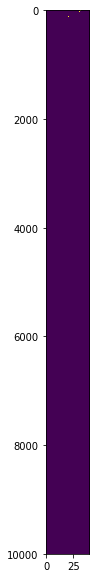

18.64


In [54]:
plt.figure(figsize=(10,10))
plt.imshow(startle_data[4], aspect=0.05)
plt.show()

startle_freq = cba.calcStartlingFrequencyWithBurning(startle_data[10], traj.par.total_time, traj.par.output)
print(startle_freq)

In [42]:
cascade_sizes, cascade_lengths, starting_points = calcCascadeSizes(startle_data[4], traj.par.output, time_margin=0.2)

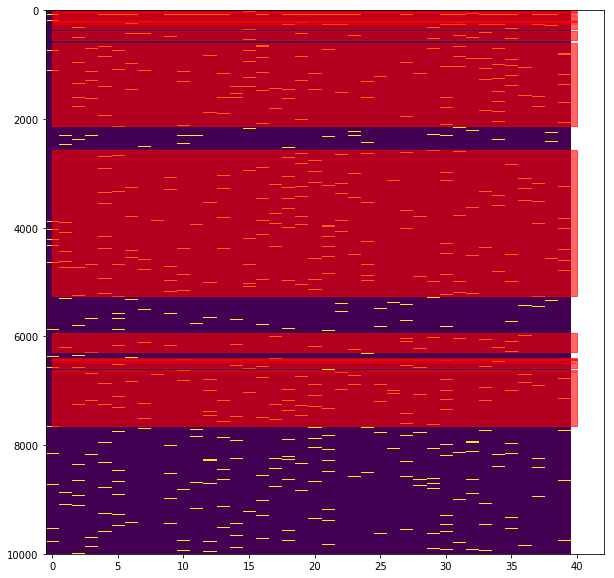

In [78]:
plt.figure(figsize=(10,10))
plt.imshow(startle_data[4], aspect='auto')

for cascade_idx in range(len(starting_points)-1):
    cascade_start = starting_points[cascade_idx]
    cascade_end = starting_points[cascade_idx] + cascade_lengths[cascade_idx]
    plt.fill_between([0, 40], [cascade_start, cascade_start], [cascade_end, cascade_end], color='r', alpha=0.6)

plt.show()

In [79]:
cascade_lengths

array([   4,    4,    6,    5,   19,   34,   13,   12,    9,   93,  171,
       1523, 2689,  352,   13,   12,   28,  101,   15,  994])

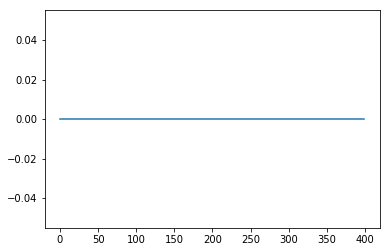

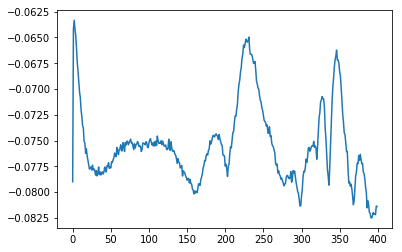

In [91]:
plt.plot(startle_data[4][0:400, 4])
plt.figure()
plt.plot(vm_data[4][0:400, 4])
plt.show()

# Startling vs. relative Orientation

In [96]:
def plot_startle_dists(ax, traj, pos_data, startle_data, burn_period):
    startle_dists, startle_distvecs = calcStartlePosition(pos_data, startle_data, traj.par.L, traj.par.output,
                                                          burn_period, None)
    all_dists, all_distvecs = calcRelativePosition(pos_data, traj.par.L, traj.par.output, burn_period, None)

    ax.hist(all_dists, density=True, label='all', alpha=0.5)
    ax.hist(startle_dists, density=True, label='startles', alpha=0.5)
    
def plot_startle_pos(ax, traj, pos_data, startle_data, burn_period):
    startle_dists, startle_distvecs = calcStartlePosition(pos_data, startle_data, traj.par.L, traj.par.output,
                                                          burn_period, None)
    if not startle_distvecs is None:
        ax.plot(startle_distvecs[:, 0], startle_distvecs[:, 1], '.', alpha=0.2)
        ax.set_xlim([-25, 25])
        ax.set_ylim([-25, 25])
    
def plot_startle_image(ax, traj, startle_data):
    cascade_sizes, cascade_lengths, starting_points = calcCascadeSizes(startle_data, traj.par.output, time_margin=0.2)
    
    ax.imshow(startle_data, aspect='auto')
    
    for cascade_idx in range(len(starting_points)-1):
        cascade_start = starting_points[cascade_idx]
        cascade_end = starting_points[cascade_idx] + cascade_lengths[cascade_idx]
        ax.fill_between([0, 40], [cascade_start, cascade_start], [cascade_end, cascade_end], color='r', alpha=0.5)
        
def plot_cascade_sizes(ax, traj, startle_data):
    cascade_sizes, cascade_lengths, starting_points = calcCascadeSizes(startle_data, traj.par.output, time_margin=0.2)
    ax.hist(cascade_sizes)
    
def plot_cascade_lengths(ax, traj, startle_data):
    cascade_sizes, cascade_lengths, starting_points = calcCascadeSizes(startle_data, traj.par.output, time_margin=0.2)
    ax.hist(cascade_lengths)
    
def plot_startle_orientations(ax, traj, pos_data, uw_data, startle_data, burn_period):
    startle_orientations, startle_frontness, all_orientations, all_frontness = calcStartleOrientation(uw_data,
                                                                                                      pos_data,
                                                                                                      startle_data,
                                                                                                      traj.par.L,
                                                                                                      traj.par.output,
                                                                                                      burn_period)

    startle_dists, startle_distvecs = calcStartlePosition(pos_data, startle_data, traj.par.L, traj.par.output,
                                                          burn_period)

    ax.hist(all_orientations, bins=20, density=True, label='all', alpha=0.5)
    ax.hist(startle_orientations, bins=20, density=True, label='startles', alpha=0.5)
    
def plot_startle_frontness(ax, traj, pos_data, uw_data, startle_data, burn_period):
    startle_orientations, startle_frontness, all_orientations, all_frontness = calcStartleOrientation(uw_data,
                                                                                                      pos_data,
                                                                                                      startle_data,
                                                                                                      traj.par.L,
                                                                                                      traj.par.output,
                                                                                                      burn_period)

    startle_dists, startle_distvecs = calcStartlePosition(pos_data, startle_data, traj.par.L, traj.par.output,
                                                          burn_period)

    ax.hist(all_frontness, bins=20, density=True, label='all', alpha=0.5)
    ax.hist(startle_frontness, bins=20, density=True, label='startles', alpha=0.5)

# Effect of mean speed and noise on speed

In [31]:
filter_params = ['speed0', 'noisep', 'vis_input_method']
ranges = {}
unique_vals = {}
lengths = []
for param_name in filter_params:
    ranges[param_name] = traj.par.f_get(param_name).f_get_range()
    unique_vals[param_name] = np.unique(ranges[param_name])
    lengths.append(len(unique_vals[param_name]))

def get_sim_data(traj, target_speed, target_noisep, target_vismethod):
    filter_func = lambda speed0, noisep, vismethod: speed0 == target_speed and noisep == target_noisep and vismethod == target_vismethod
    filter_params = ['speed0', 'noisep', 'vis_input_method']
    idx_iterator = traj.f_find_idx(filter_params, filter_func)

    pos_data = []
    uw_data = []
    startle_data = []
    vm_data = []
    # fill result arrays
    for run_idx in idx_iterator:
        traj.v_idx = run_idx
        pos_data.append(traj.f_get('results.outdata.crun.pos', fast_access=True, auto_load=True))
        uw_data.append(traj.f_get('results.outdata.crun.uw', fast_access=True, auto_load=True))
        startle_data.append(traj.f_get('results.outdata.crun.startle', fast_access=True, auto_load=True))
        vm_data.append(traj.f_get('results.outdata.crun.v_m', fast_access=True, auto_load=True))
        
    return pos_data[0], uw_data[0], startle_data[0], vm_data[0]    

# Startle distance:

/home/warkentin/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


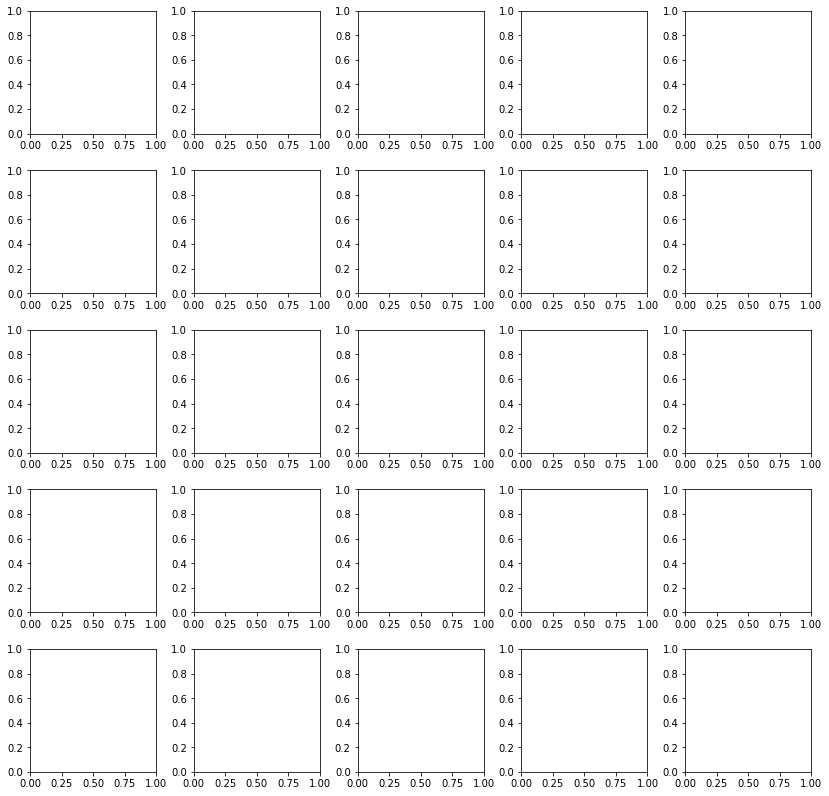

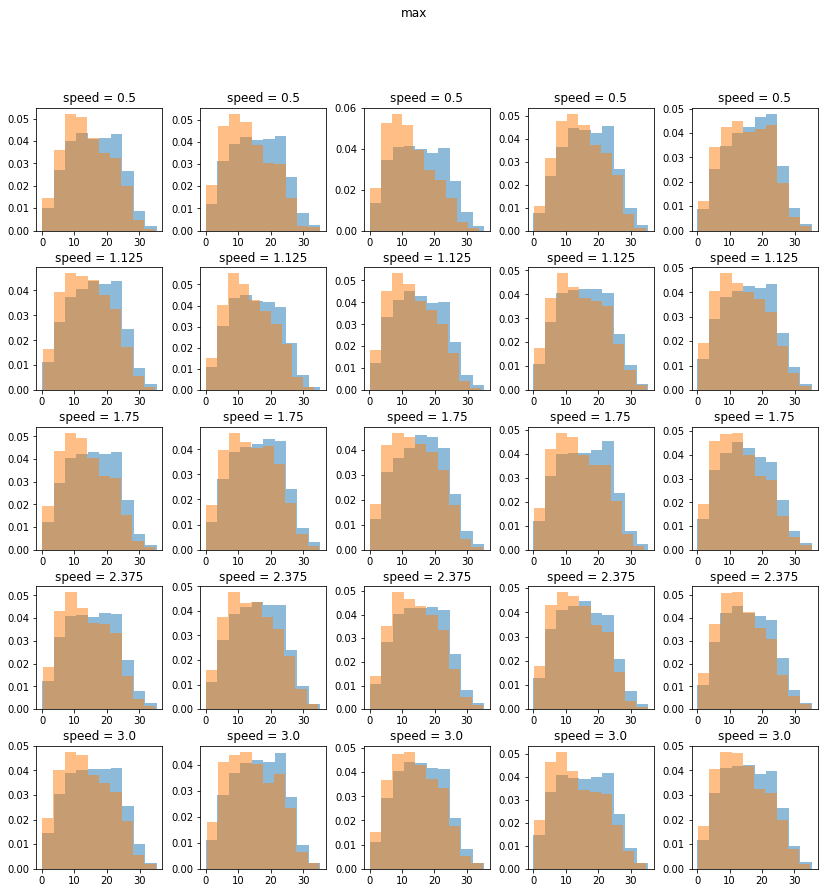

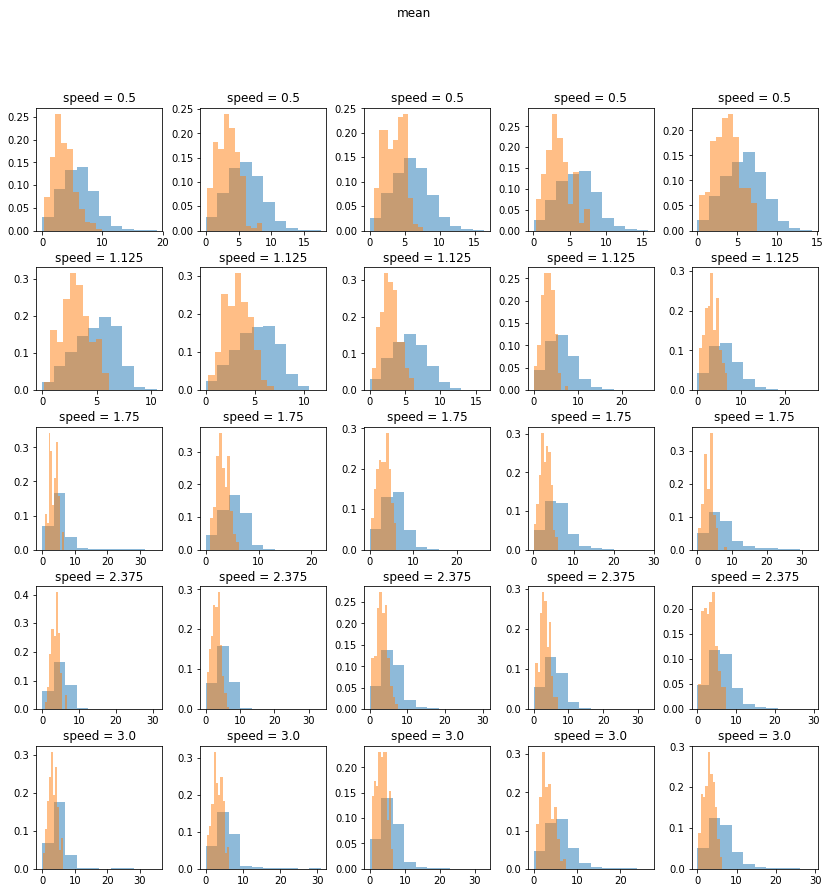

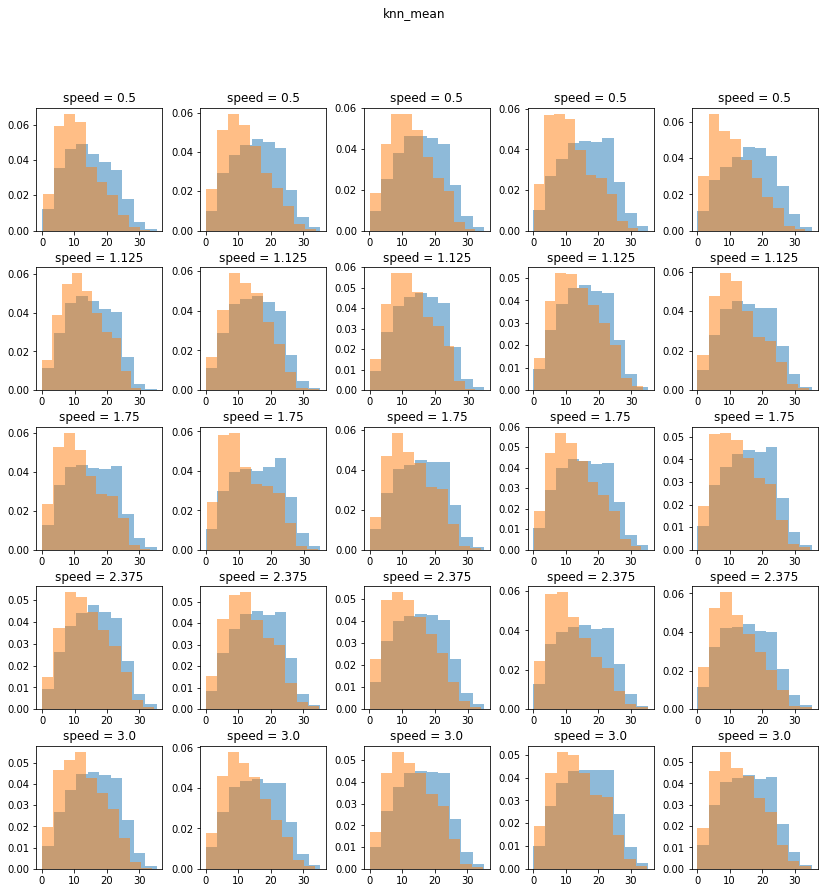

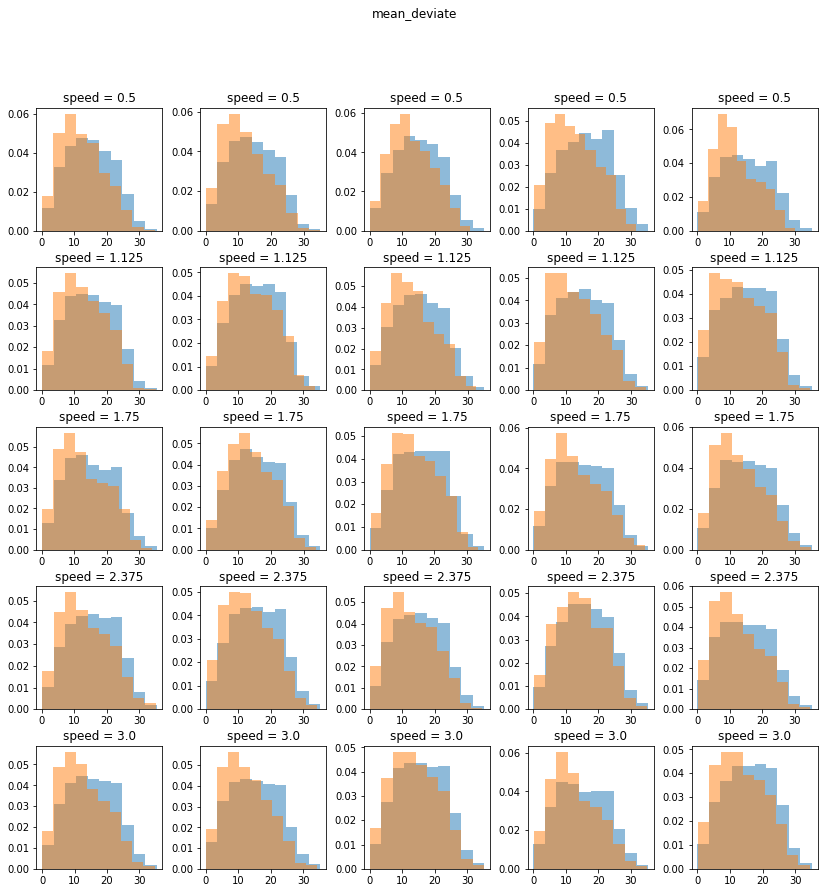

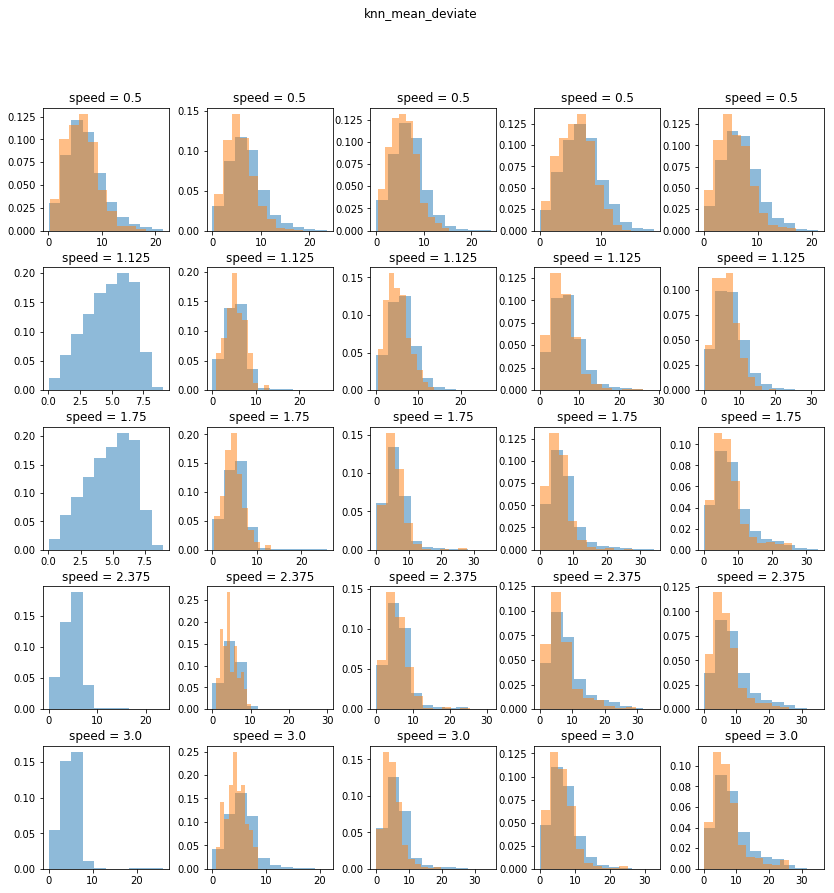

In [32]:
vismethods = ['max', 'mean', 'knn_mean', 'mean_deviate', 'knn_mean_deviate']
for vismethod in vismethods:
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(14, 14))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    for speed_idx, cspeed in enumerate(unique_vals['speed0']):
        for noise_idx, cnoisep in enumerate(unique_vals['noisep']):
            pos_data, uw_data, startle_data, vm_data = get_sim_data(traj, cspeed, cnoisep, vismethod)
            plot_startle_dists(axes[speed_idx, noise_idx], traj, pos_data, startle_data, burn_period=50)
            axes[speed_idx, noise_idx].set_title('speed = ' + str(cspeed))
            
    plt.suptitle(vismethod)
plt.show()
        

# Startle position

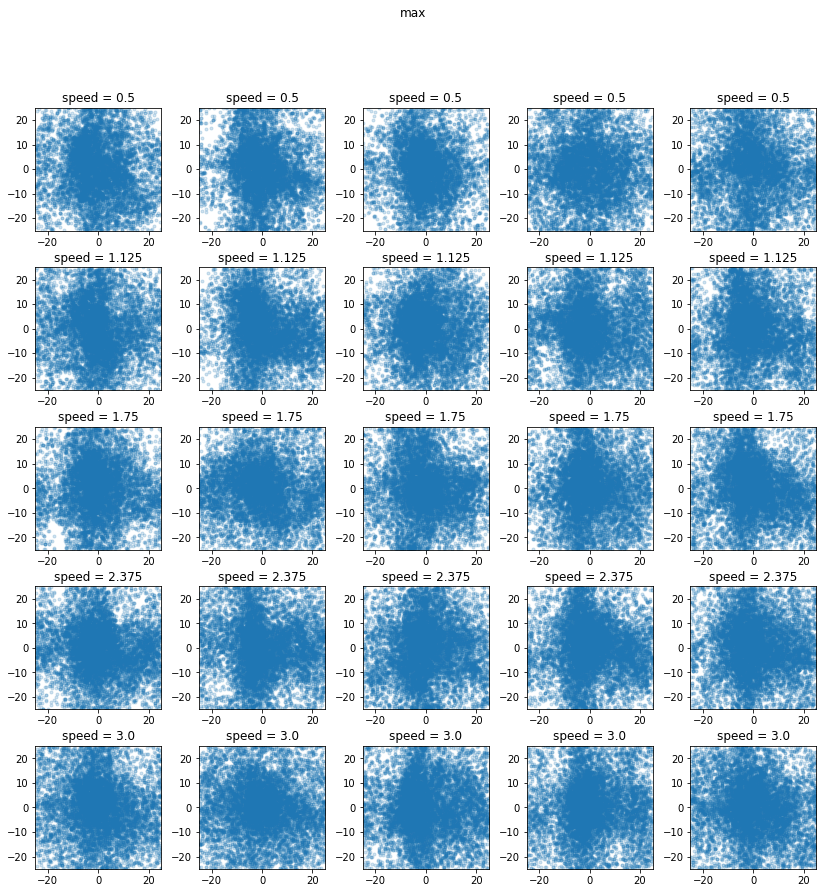

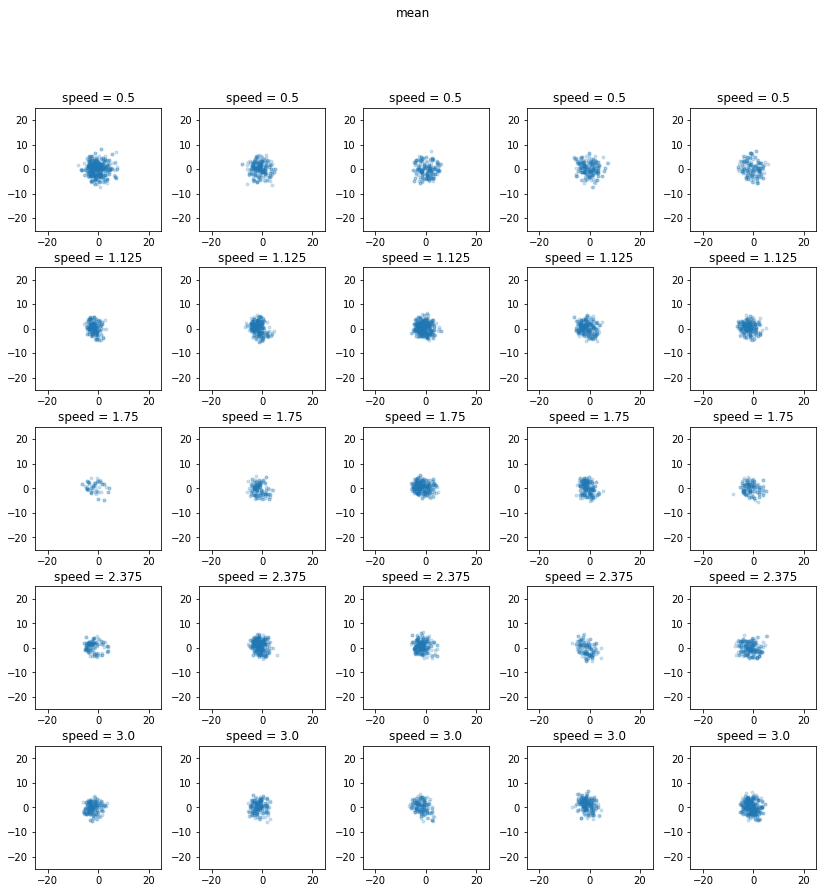

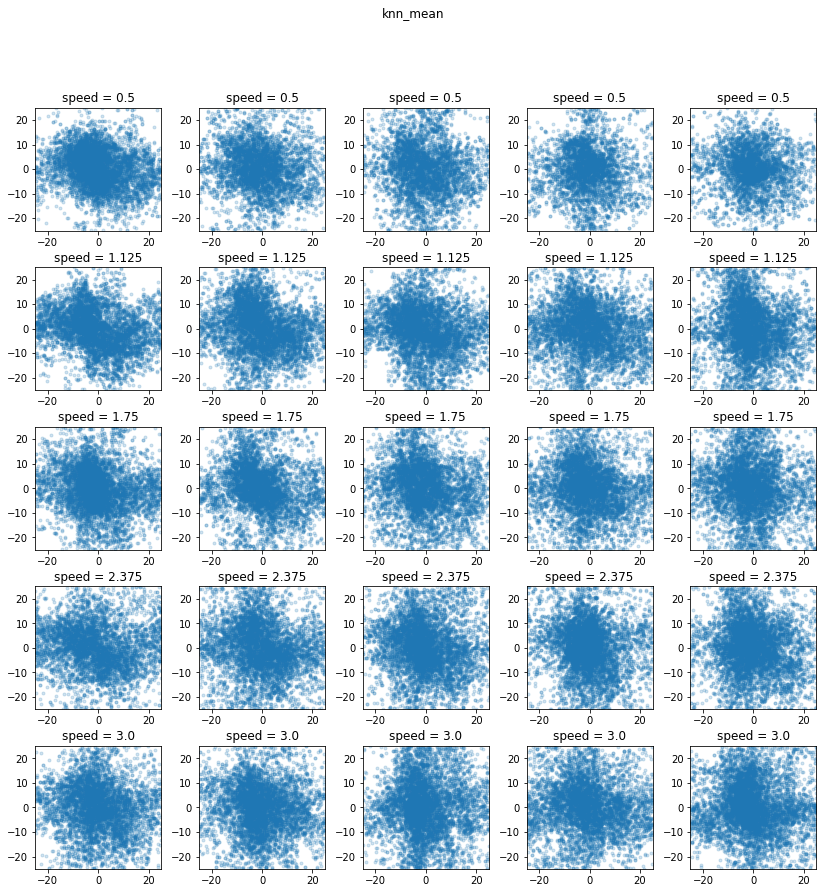

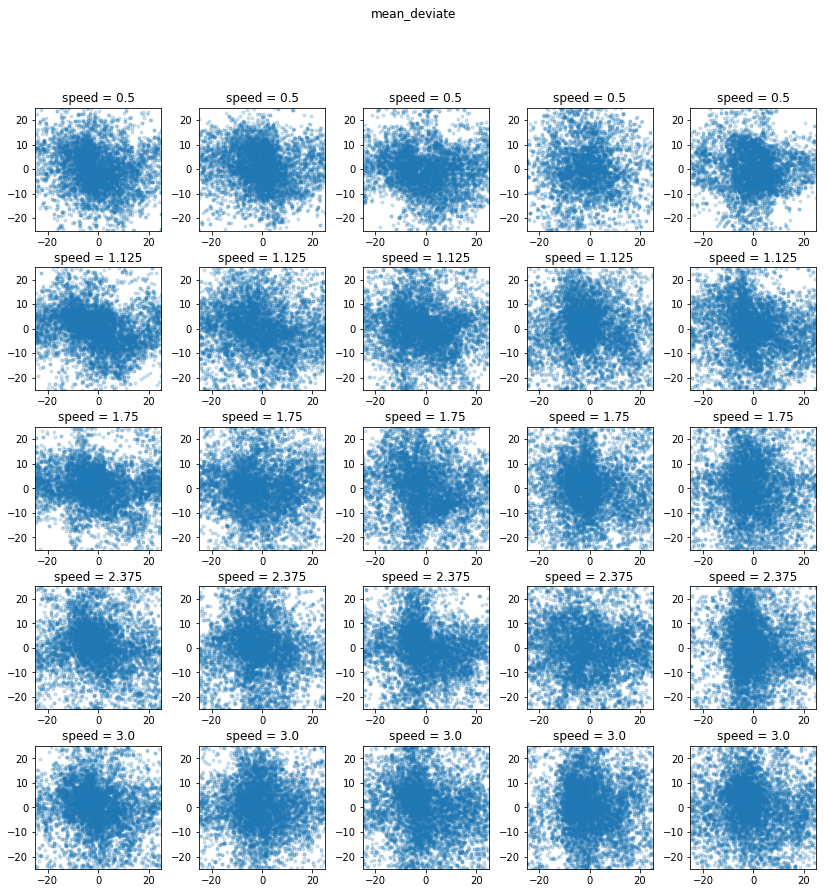

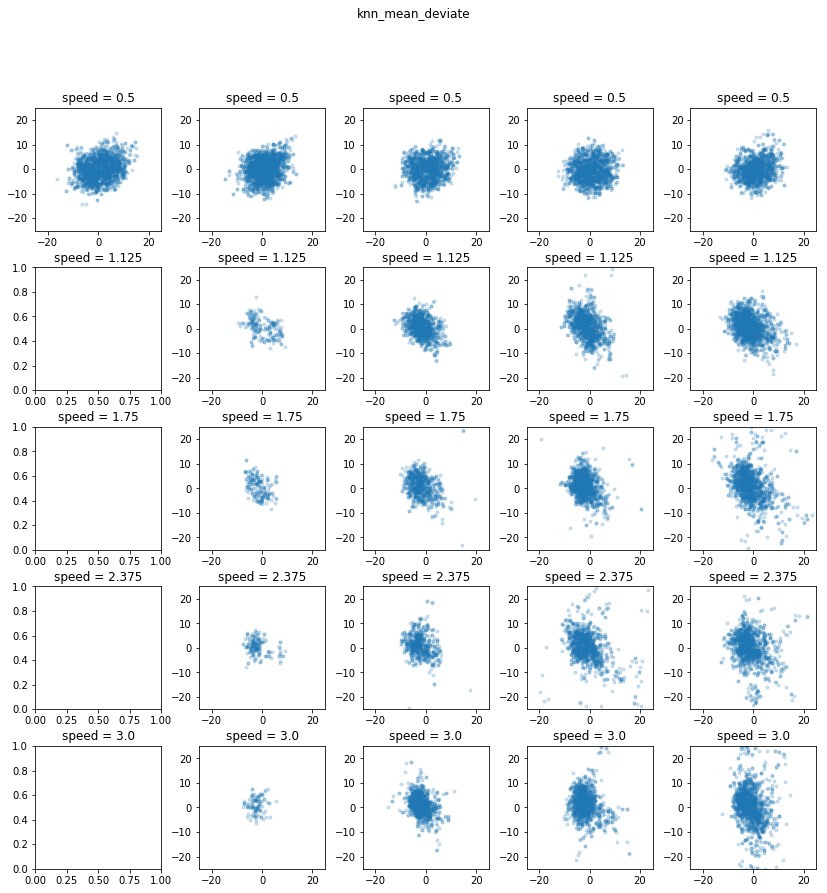

In [33]:
vismethods = ['max', 'mean', 'knn_mean', 'mean_deviate', 'knn_mean_deviate']
for vismethod in vismethods:
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(14, 14))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    for speed_idx, cspeed in enumerate(unique_vals['speed0']):
        for noise_idx, cnoisep in enumerate(unique_vals['noisep']):
            pos_data, uw_data, startle_data, vm_data = get_sim_data(traj, cspeed, cnoisep, vismethod)
            plot_startle_pos(axes[speed_idx, noise_idx], traj, pos_data, startle_data, burn_period=50)
            axes[speed_idx, noise_idx].set_title('speed = ' + str(cspeed))
            
    plt.suptitle(vismethod)
plt.show()
        

# Startle pattern

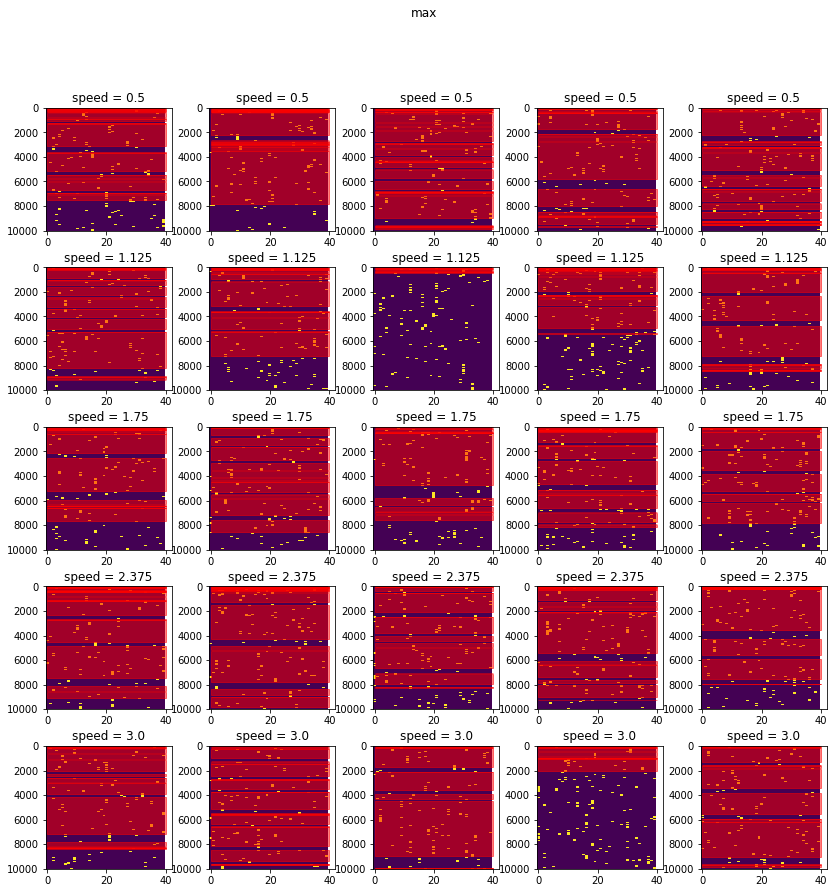

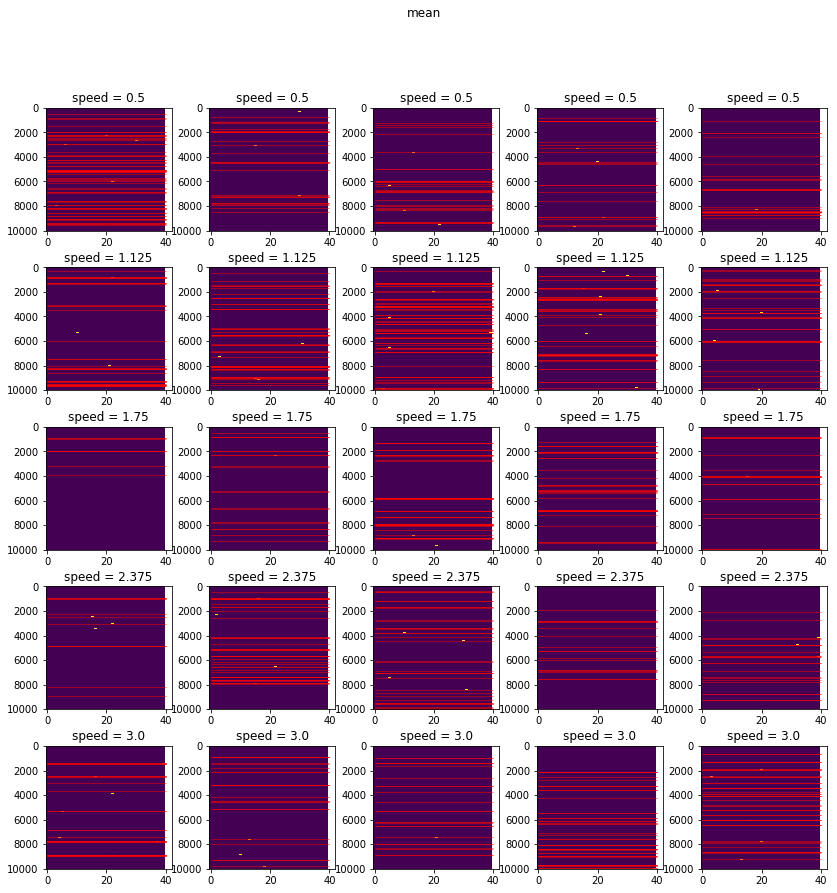

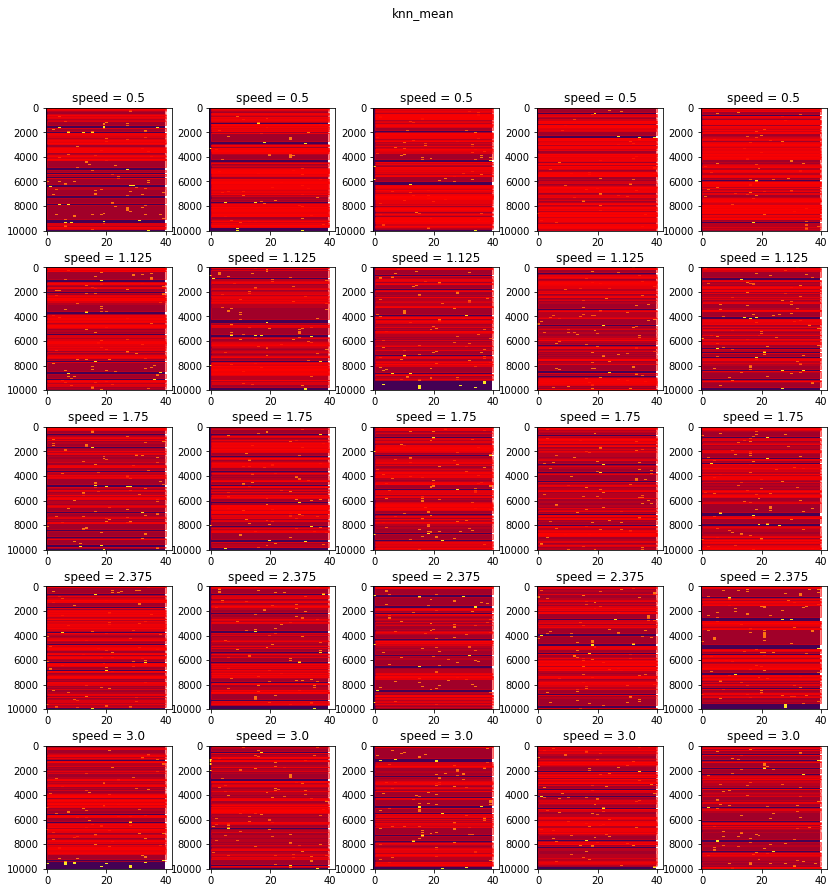

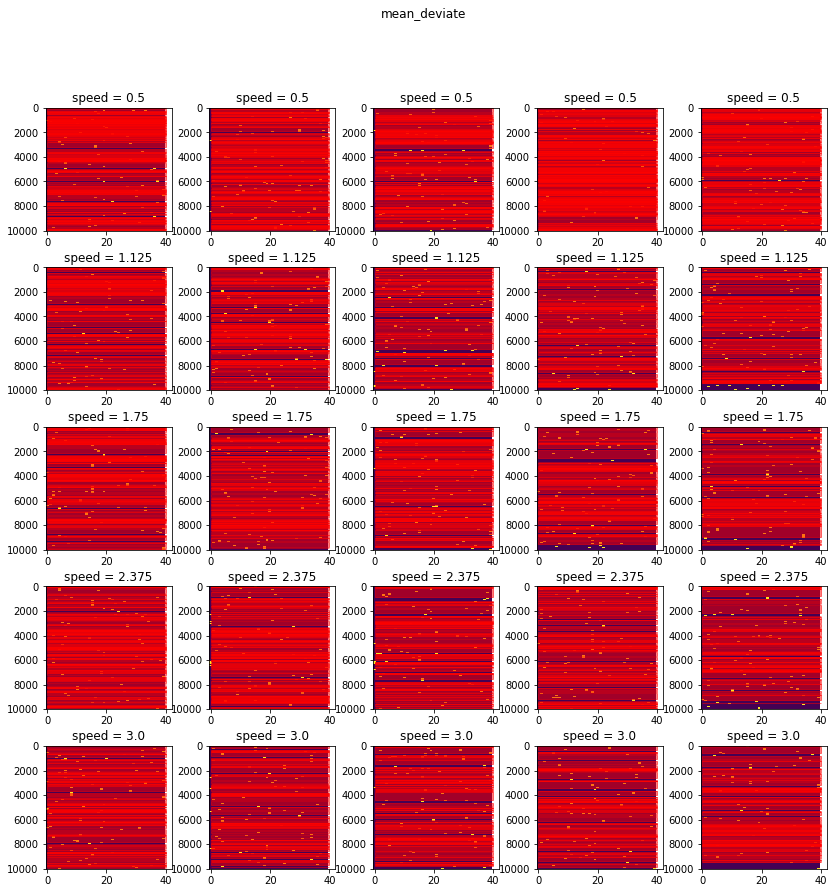

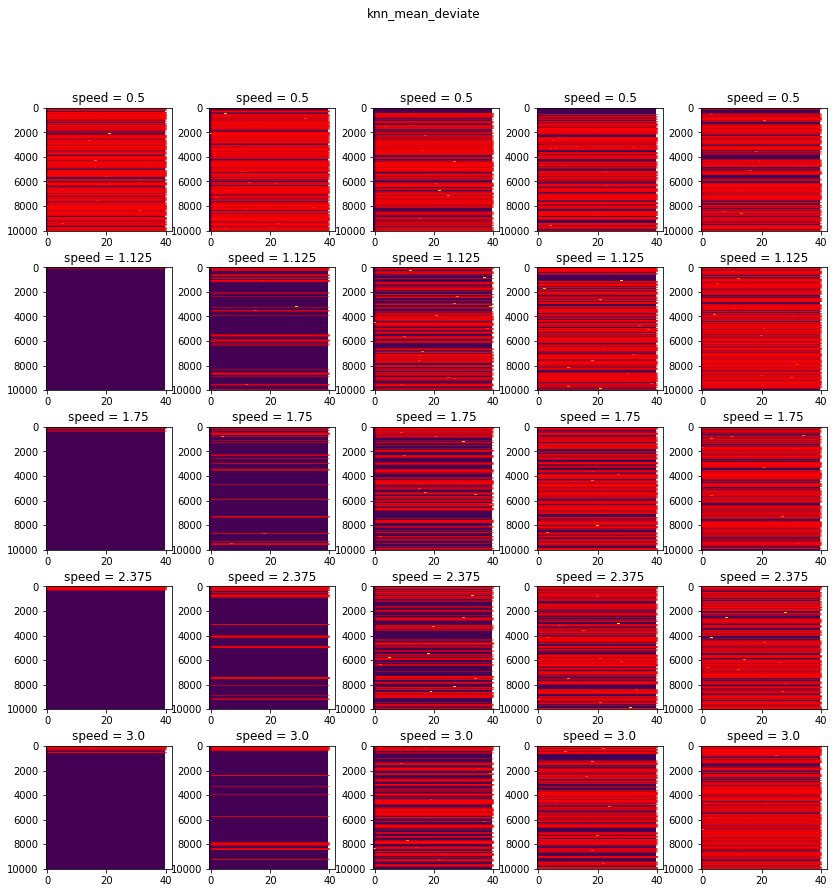

In [95]:
vismethods = ['max', 'mean', 'knn_mean', 'mean_deviate', 'knn_mean_deviate']
for vismethod in vismethods:
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(14, 14))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    for speed_idx, cspeed in enumerate(unique_vals['speed0']):
        for noise_idx, cnoisep in enumerate(unique_vals['noisep']):
            pos_data, uw_data, startle_data, vm_data = get_sim_data(traj, cspeed, cnoisep, vismethod)
            plot_startle_image(axes[speed_idx, noise_idx], traj, startle_data)
            axes[speed_idx, noise_idx].set_title('speed = ' + str(cspeed))
            
    plt.suptitle(vismethod)
plt.show()

# Startle orientation

/home/warkentin/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


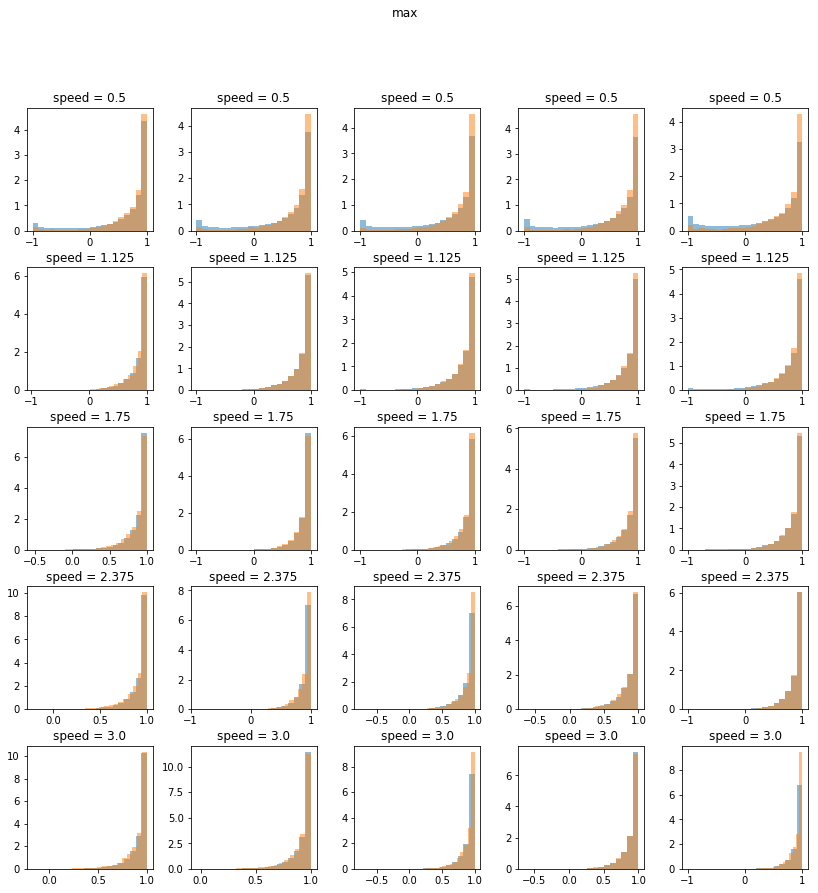

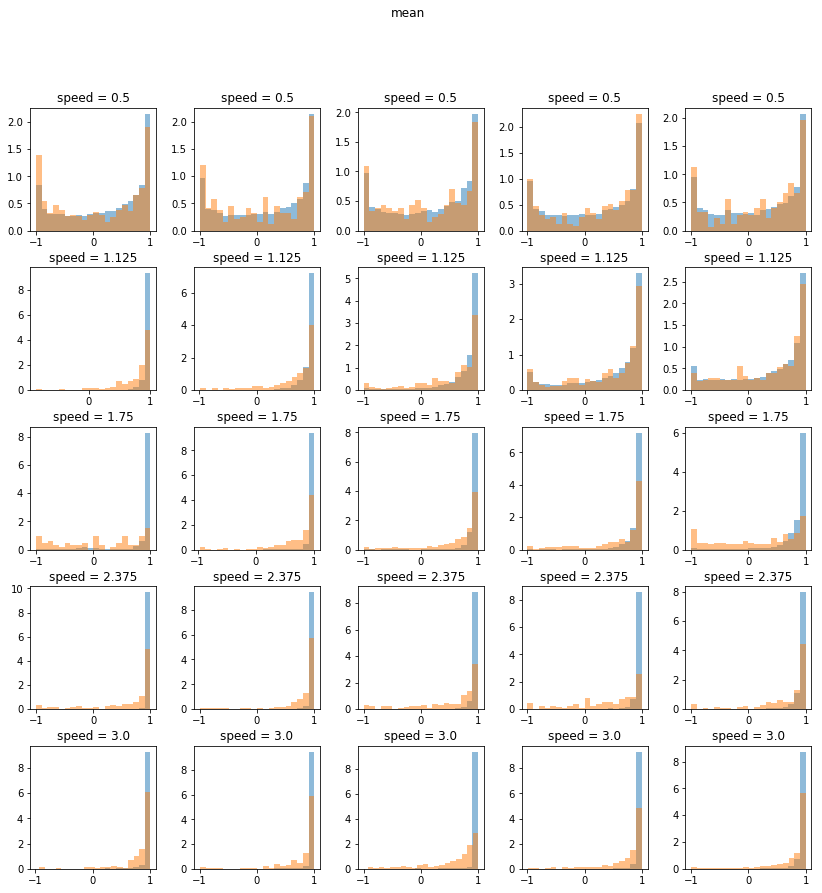

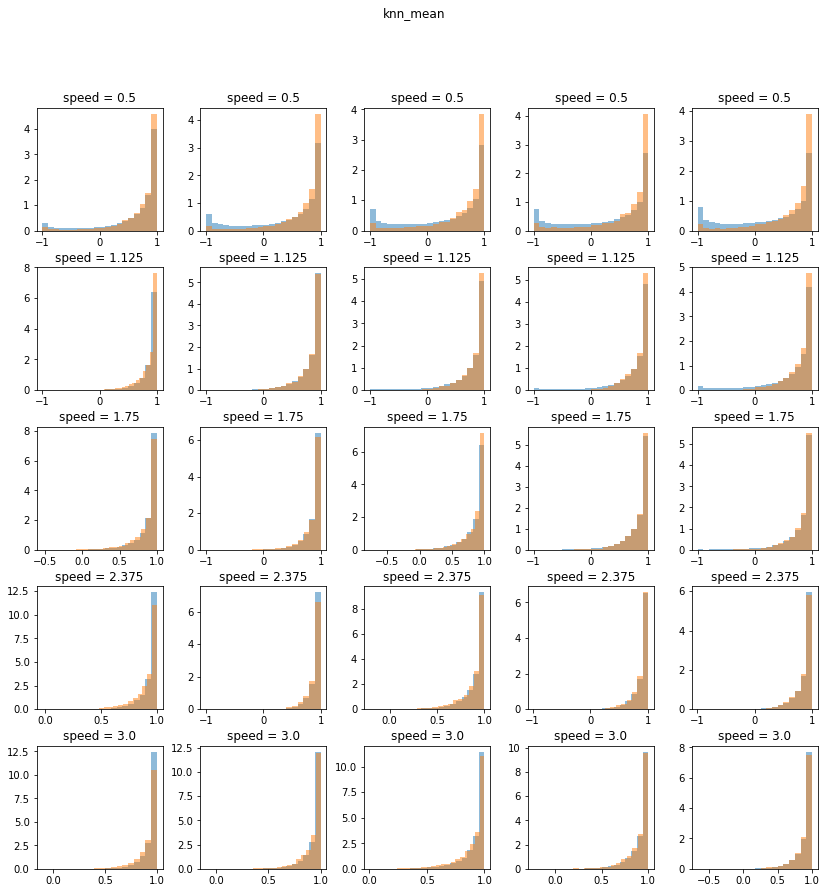

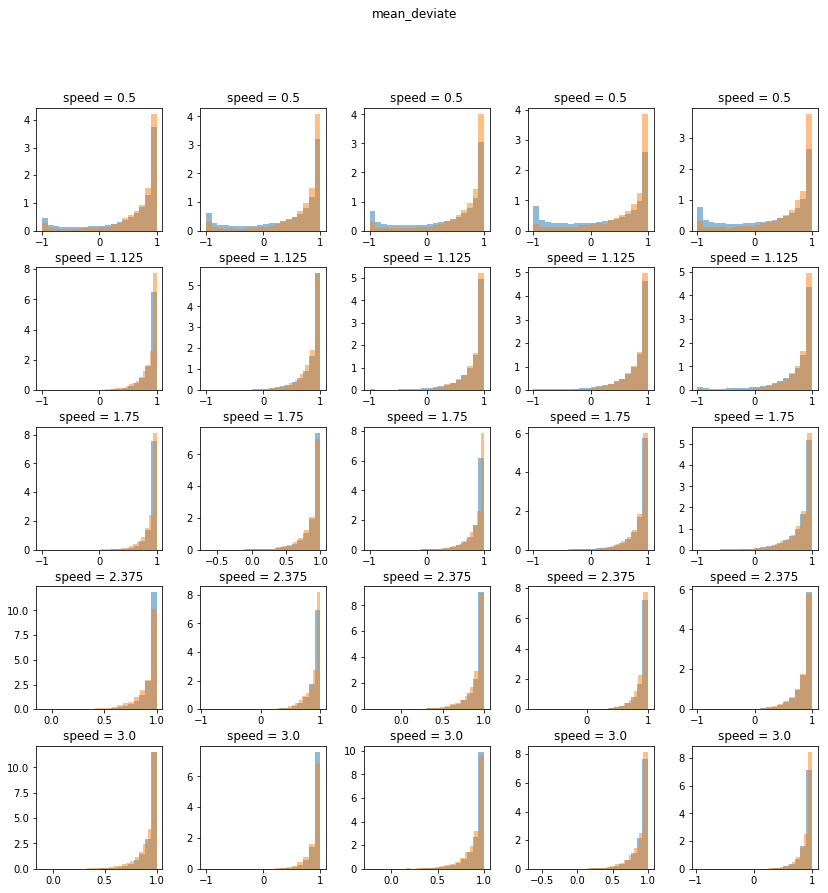

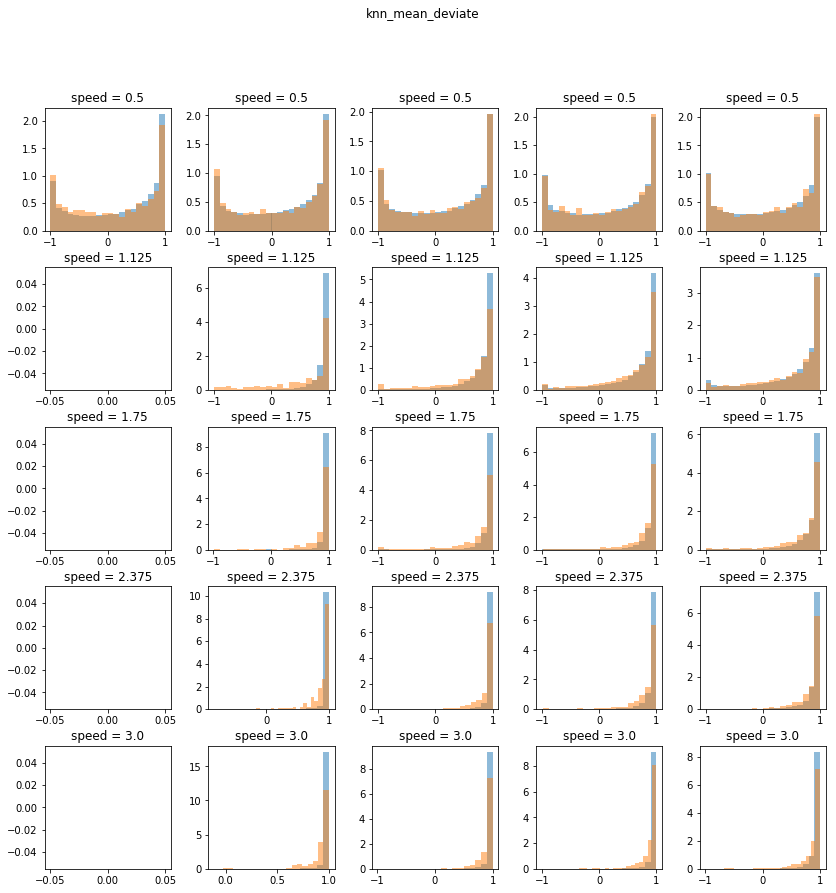

In [35]:
vismethods = ['max', 'mean', 'knn_mean', 'mean_deviate', 'knn_mean_deviate']
for vismethod in vismethods:
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(14, 14))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    for speed_idx, cspeed in enumerate(unique_vals['speed0']):
        for noise_idx, cnoisep in enumerate(unique_vals['noisep']):
            pos_data, uw_data, startle_data, vm_data = get_sim_data(traj, cspeed, cnoisep, vismethod)
            plot_startle_orientations(axes[speed_idx, noise_idx], traj, pos_data, uw_data, startle_data, burn_period=50)
            axes[speed_idx, noise_idx].set_title('speed = ' + str(cspeed))
            
    plt.suptitle(vismethod)
plt.show()

# Startle "frontness"

/home/warkentin/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


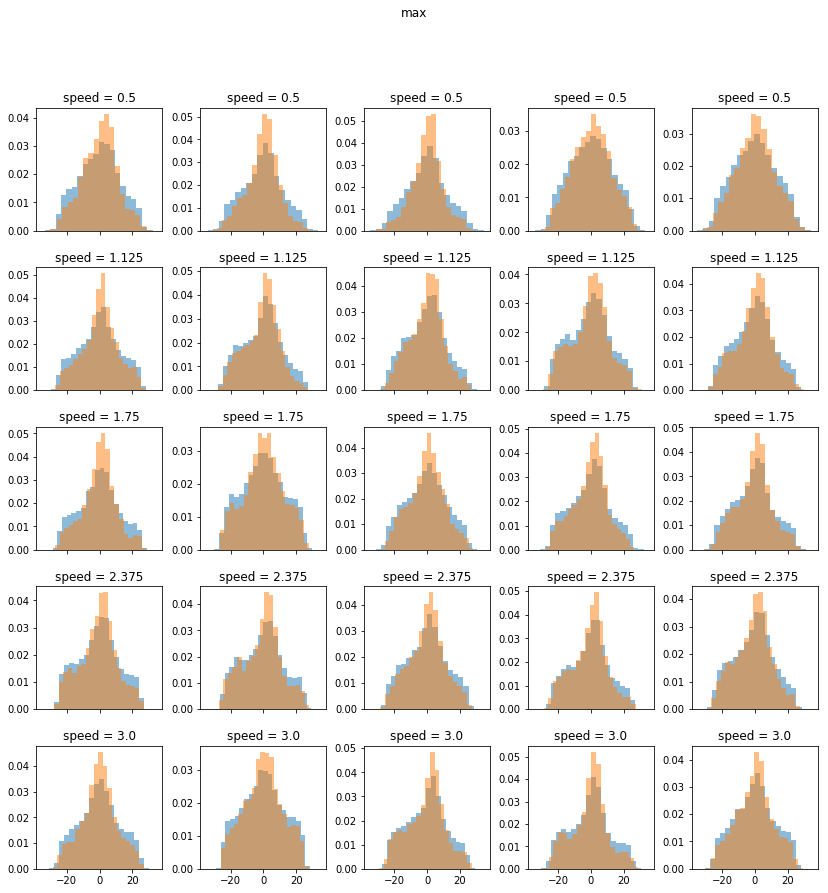

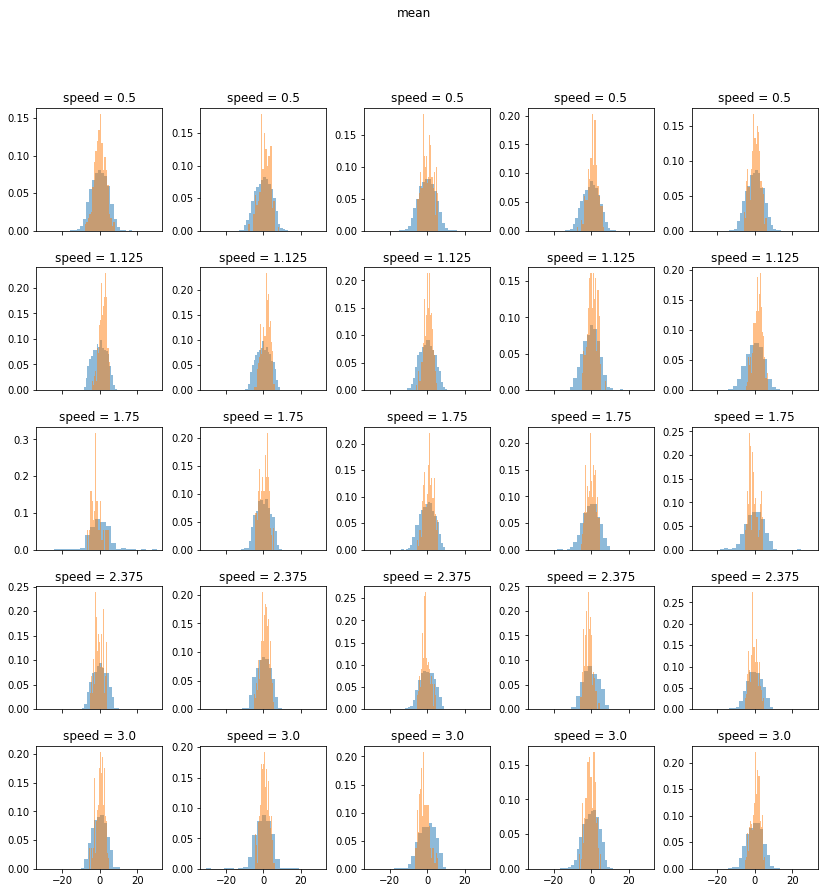

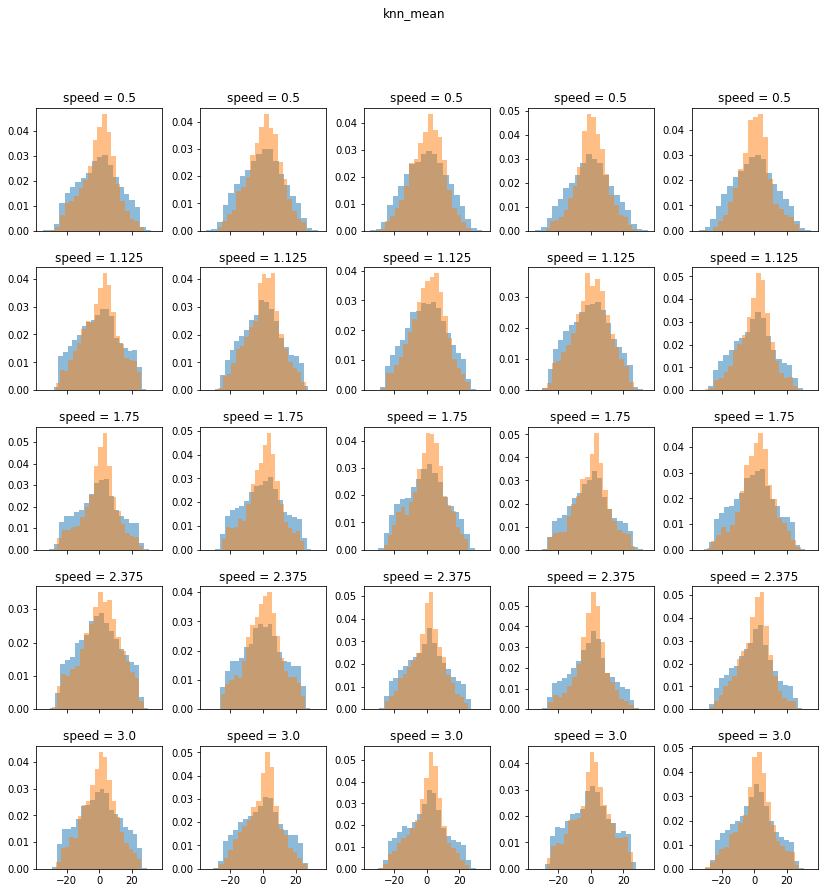

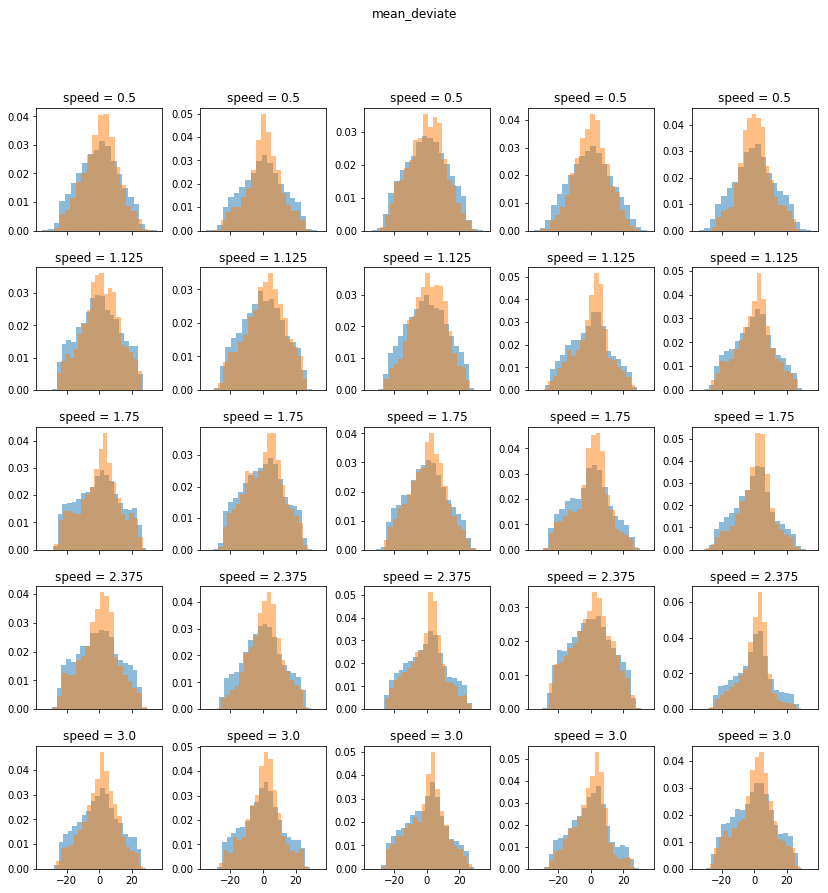

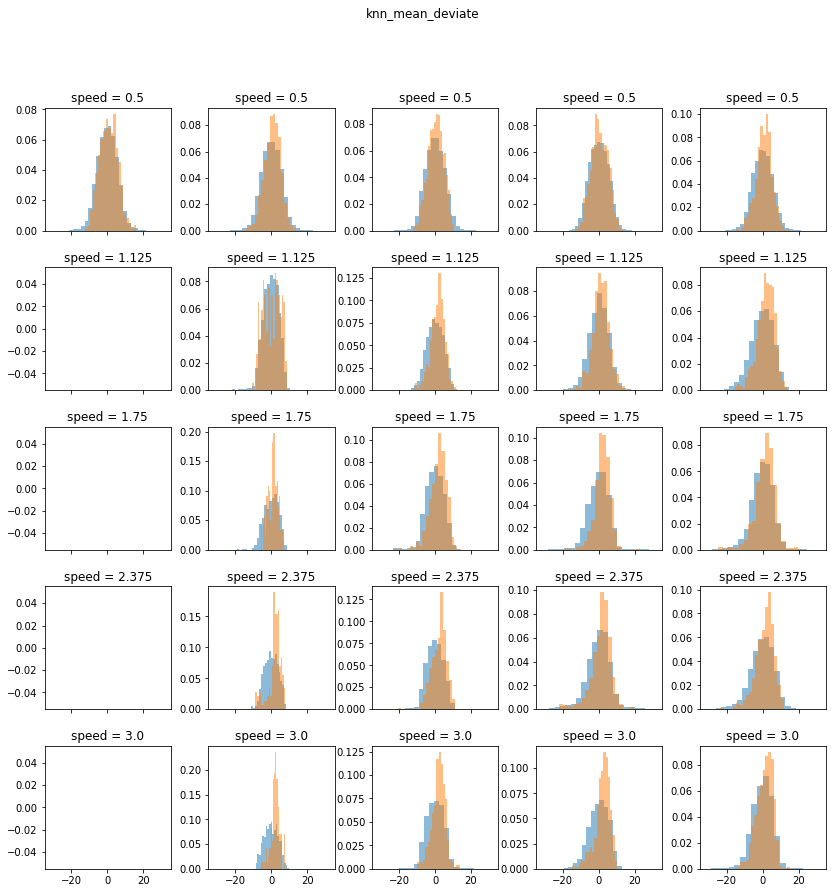

In [36]:
vismethods = ['max', 'mean', 'knn_mean', 'mean_deviate', 'knn_mean_deviate']
for vismethod in vismethods:
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(14, 14), sharex=True, sharey=False)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    for speed_idx, cspeed in enumerate(unique_vals['speed0']):
        for noise_idx, cnoisep in enumerate(unique_vals['noisep']):
            pos_data, uw_data, startle_data, vm_data = get_sim_data(traj, cspeed, cnoisep, vismethod)
            plot_startle_frontness(axes[speed_idx, noise_idx], traj, pos_data, uw_data, startle_data, burn_period=50)
            axes[speed_idx, noise_idx].set_title('speed = ' + str(cspeed))
            
    plt.suptitle(vismethod)
plt.show()

# Cascade sizes

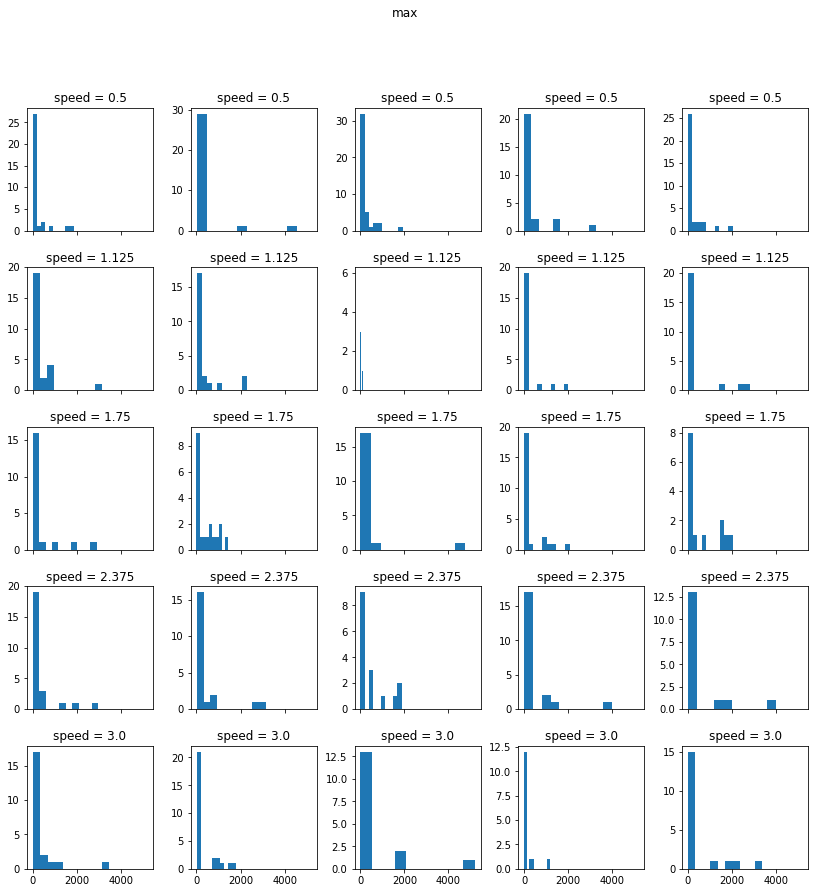

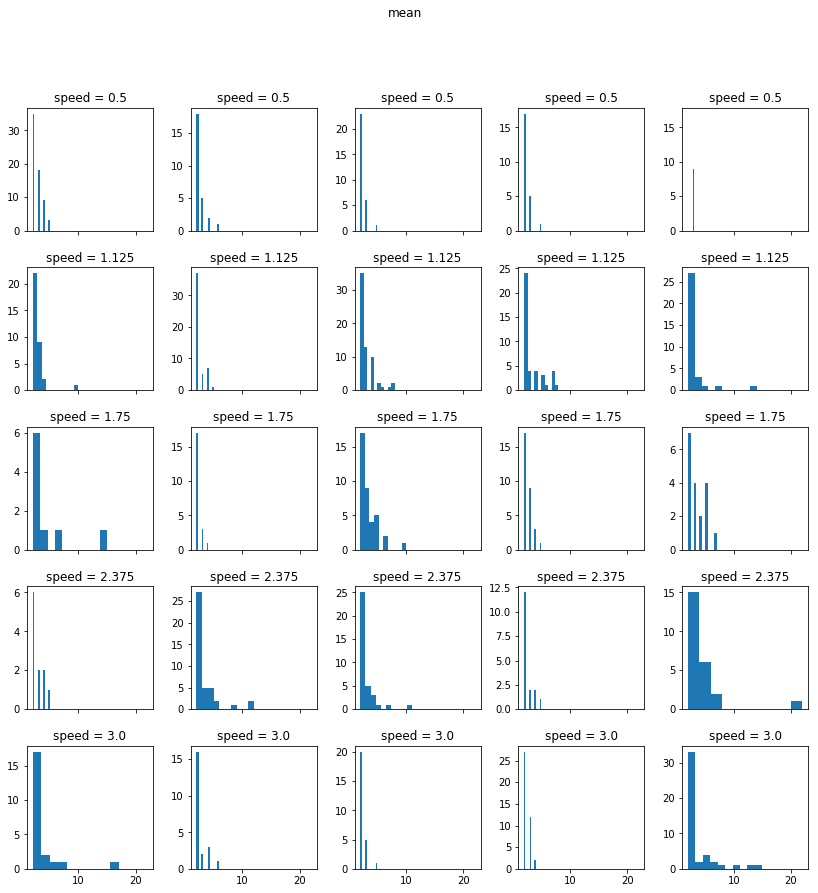

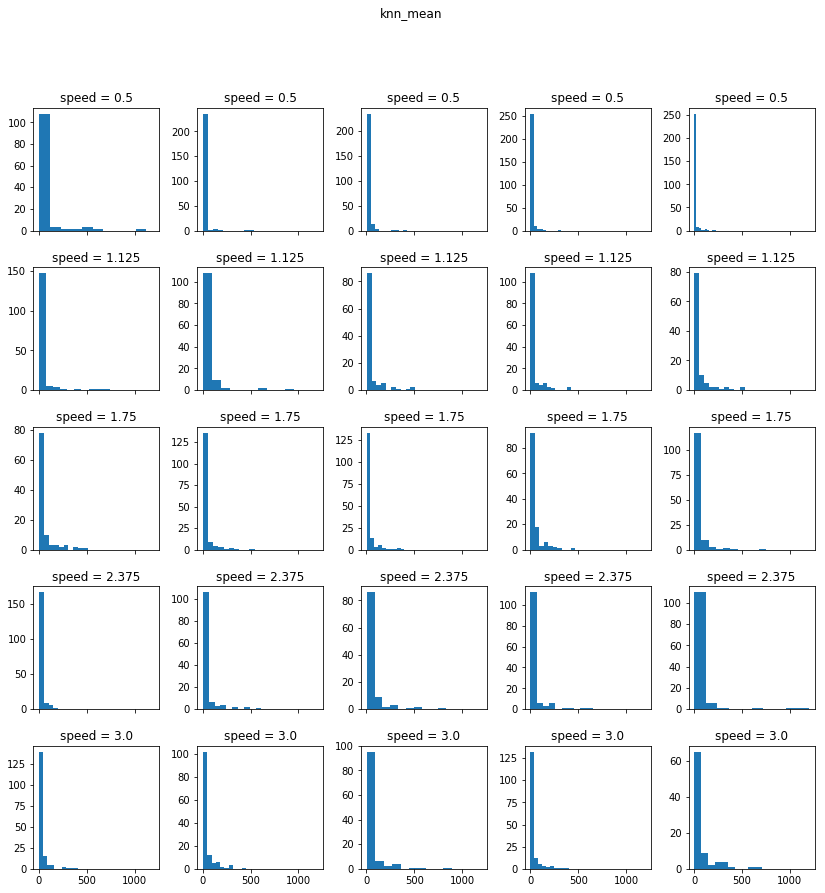

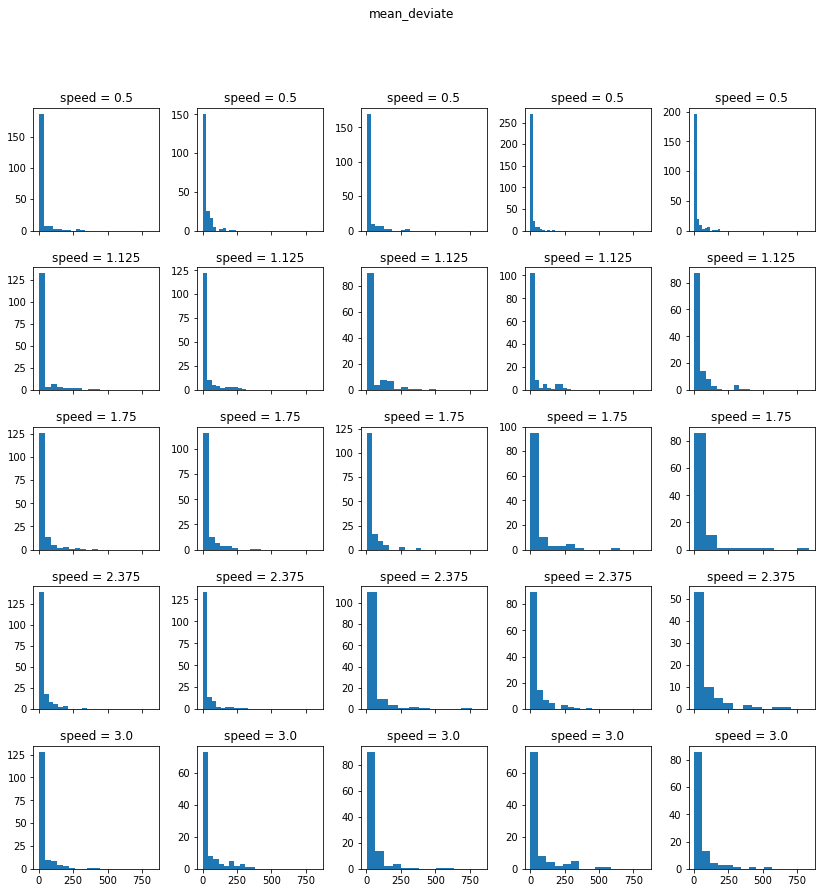

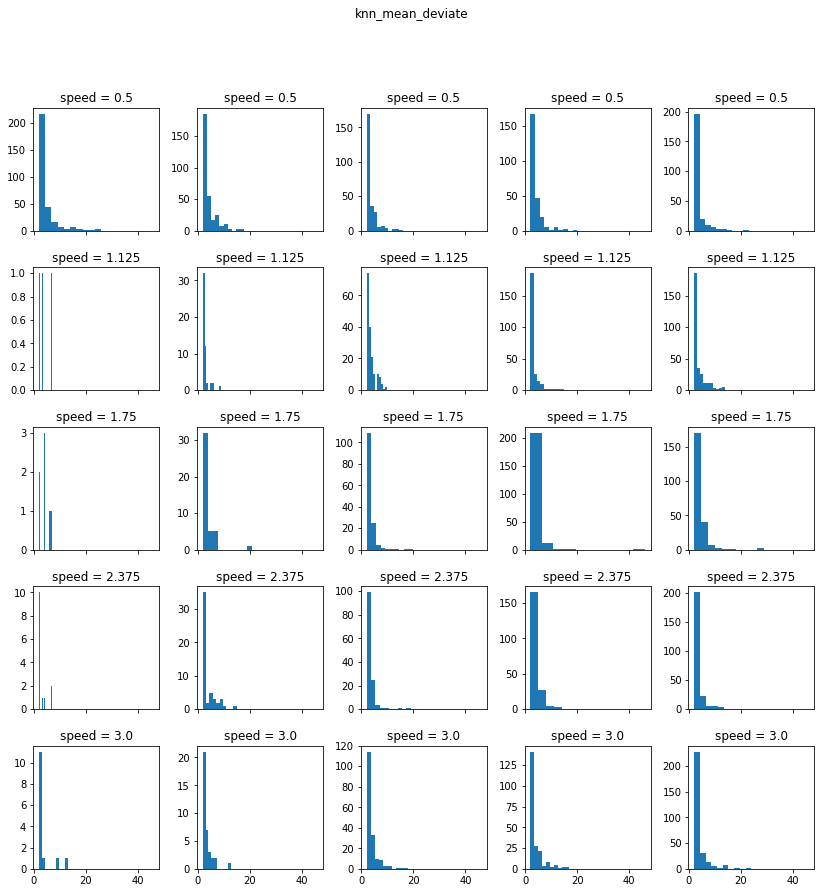

In [98]:
vismethods = ['max', 'mean', 'knn_mean', 'mean_deviate', 'knn_mean_deviate']
for vismethod in vismethods:
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(14, 14), sharex=True)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    for speed_idx, cspeed in enumerate(unique_vals['speed0']):
        for noise_idx, cnoisep in enumerate(unique_vals['noisep']):
            pos_data, uw_data, startle_data, vm_data = get_sim_data(traj, cspeed, cnoisep, vismethod)
            plot_cascade_sizes(axes[speed_idx, noise_idx], traj, startle_data)
            axes[speed_idx, noise_idx].set_title('speed = ' + str(cspeed))
            
    plt.suptitle(vismethod)
plt.show()

# Cascade lengths

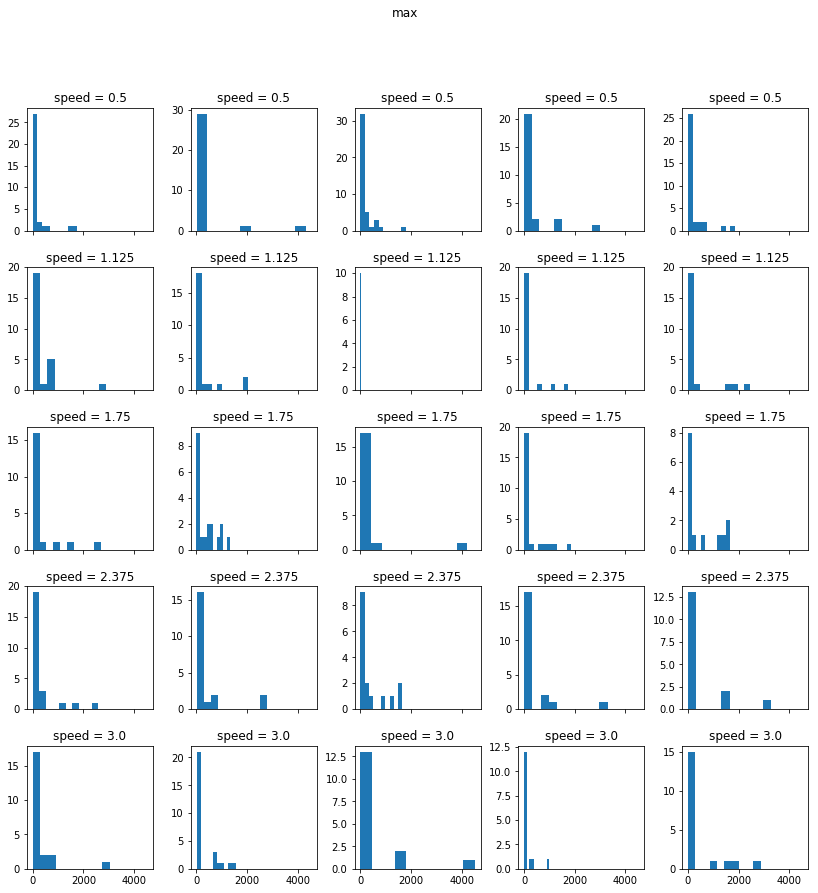

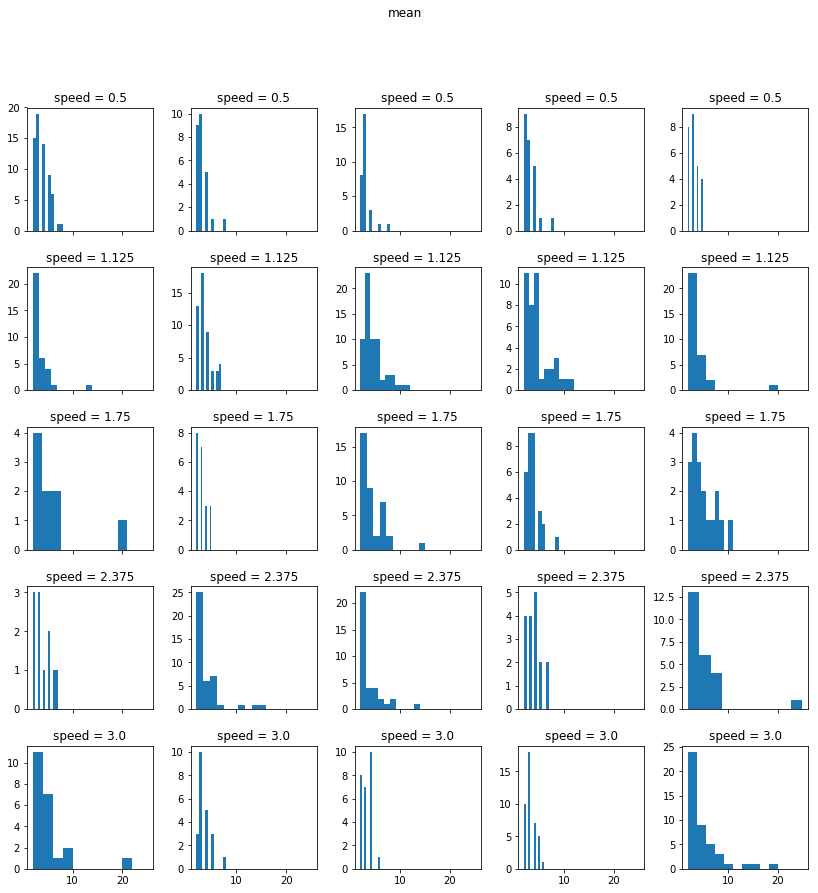

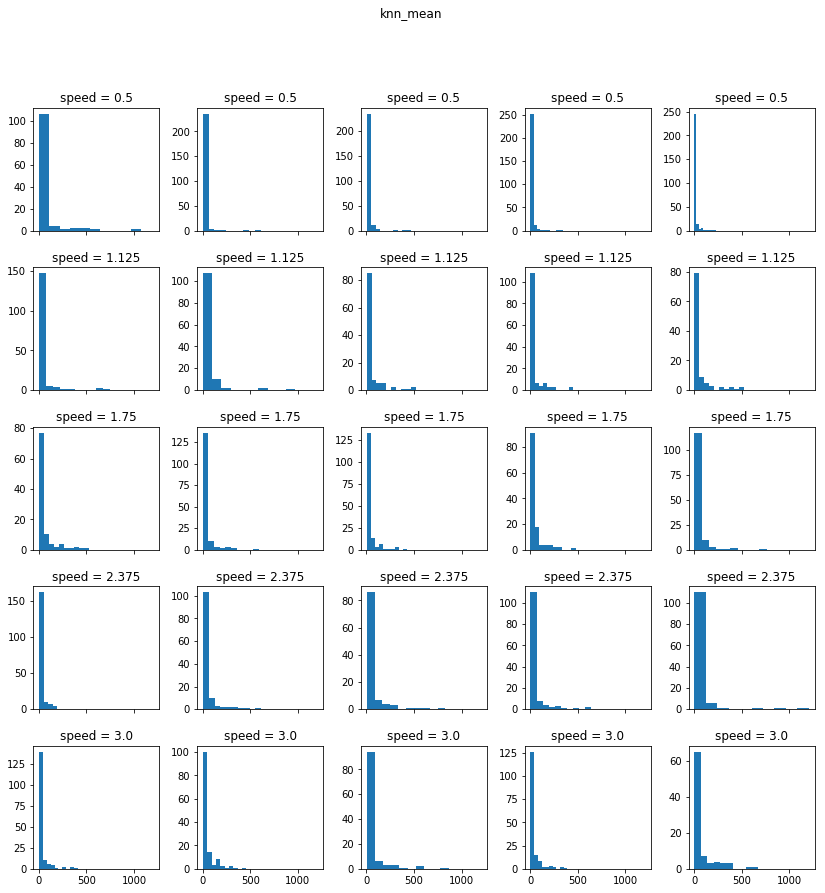

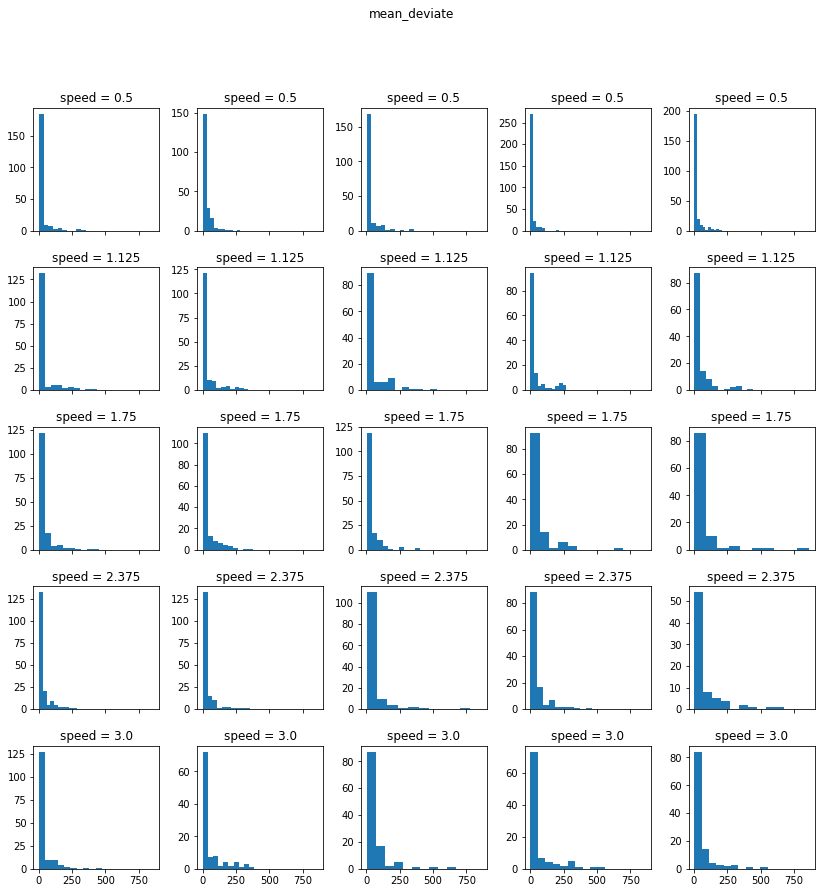

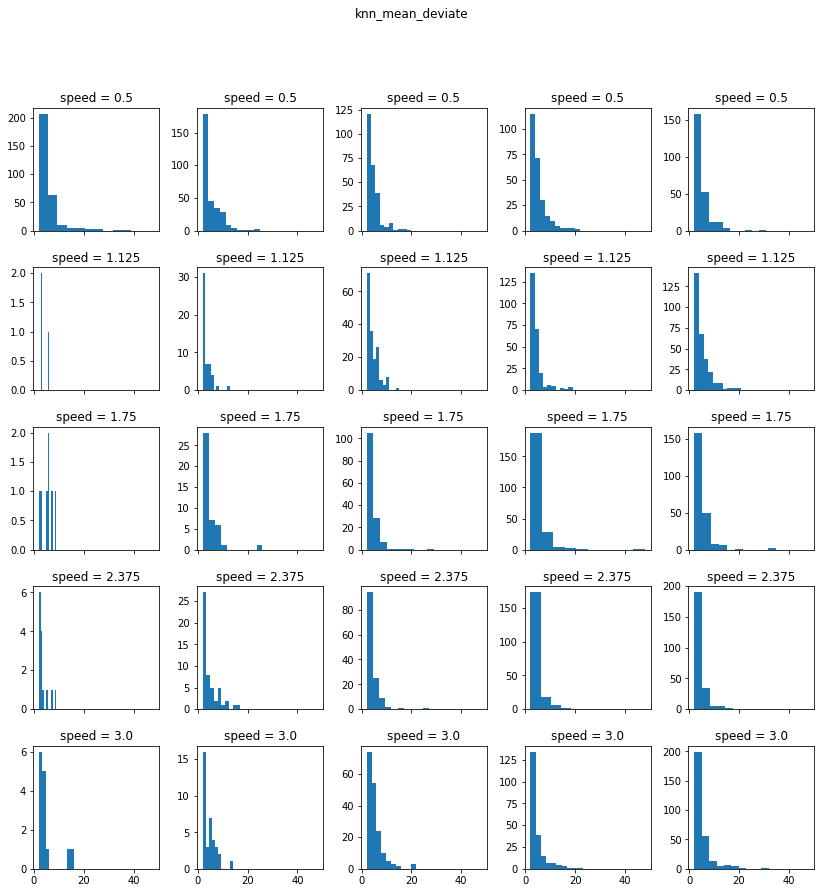

In [99]:
vismethods = ['max', 'mean', 'knn_mean', 'mean_deviate', 'knn_mean_deviate']
for vismethod in vismethods:
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(14, 14), sharex=True)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    for speed_idx, cspeed in enumerate(unique_vals['speed0']):
        for noise_idx, cnoisep in enumerate(unique_vals['noisep']):
            pos_data, uw_data, startle_data, vm_data = get_sim_data(traj, cspeed, cnoisep, vismethod)
            plot_cascade_lengths(axes[speed_idx, noise_idx], traj, startle_data)
            axes[speed_idx, noise_idx].set_title('speed = ' + str(cspeed))
            
    plt.suptitle(vismethod)
plt.show()